In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = filepath = "../Dataset/"
crime_df = pd.read_csv(file_path + "Clean/crime_stats_2013_2025.csv", encoding='utf-8', header=0)
crime_df.head()

report_date          suburb postcode                offence_lv1  \
0   1/07/2013  ABERFOYLE PARK     5159  OFFENCES AGAINST PROPERTY   
1   1/07/2013        ADELAIDE     5000  OFFENCES AGAINST PROPERTY   
2   1/07/2013        ADELAIDE     5000  OFFENCES AGAINST PROPERTY   
3   1/07/2013        ADELAIDE     5000  OFFENCES AGAINST PROPERTY   
4   1/07/2013        ADELAIDE     5000  OFFENCES AGAINST PROPERTY   

                         offence_lv2                              offence_lv3  \
0          SERIOUS CRIMINAL TRESPASS                      SCT - Non Residence   
1  PROPERTY DAMAGE AND ENVIRONMENTAL                                 Graffiti   
2  PROPERTY DAMAGE AND ENVIRONMENTAL  Other property damage and environmental   
3          SERIOUS CRIMINAL TRESPASS                      SCT - Non Residence   
4         THEFT AND RELATED OFFENCES                              Other theft   

   offence_count  
0            1.0  
1            2.0  
2            2.0  
3            1.0  
4            3.0

In [4]:
house_price_df = pd.read_csv(file_path + "Clean/sa_house_price_2015_2025.csv", encoding='utf-8', header=0)
house_price_df.head()

city                 suburb  sales    median  \
0  ADELAIDE              ADELAIDE                 6.0  757500.0   
1  ADELAIDE              NORTH ADELAIDE           4.0  992500.0   
2  ADELAIDE HILLS        ALDGATE                 17.0  685000.0   
3  ADELAIDE HILLS        BALHANNAH                9.0  439000.0   
4  ADELAIDE HILLS        BELAIR                  18.0  595000.0   

   median_change  year quarter  
0       0.169884  2015      Q1  
1      -0.097727  2015      Q1  
2       0.132231  2015      Q1  
3       0.310448  2015      Q1  
4       0.117371  2015      Q1

In [5]:
gdf = gpd.read_file(filepath + "Adl_Suburbs/Suburbs_shp/Suburbs_GDA94.shp")
gdf.head()

postcode                                 suburb  suburb_num legalstart  \
0     0872                                  AMATA       87206        NaT   
1     0872  ANANGU PITJANTJATJARA YANKUNYTJATJARA       87205        NaT   
2     0872                      AYERS RANGE SOUTH       87202 2013-04-26   
3     0872                           DE ROSE HILL       87201 2013-04-26   
4     0872                                IWANTJA       87209        NaT   

   shape_Leng  shape_Area                                           geometry  
0    0.258467    0.003273  POLYGON ((131.21647 -26.11914, 131.14123 -26.1...  
1   16.039189    9.288721  POLYGON ((132.97729 -25.99857, 133.05763 -25.9...  
2    1.466853    0.117333  POLYGON ((133.458 -25.99856, 133.45829 -26.004...  
3    1.685683    0.167840  POLYGON ((133.42463 -26.4087, 133.42602 -26.44...  
4    0.143983    0.001144  POLYGON ((133.30662 -26.9931, 133.30002 -26.99...

# Integrate

In [6]:
def get_quarter(month):
    quarter = None
    if month <= 3:
        quarter = "Q1"
    elif month <= 6:
        quarter = "Q2"
    elif month <= 9:
        quarter = "Q3"
    elif month <= 12:
        quarter = "Q4"
    return quarter

# report date to datetime data
crime_clean_df = crime_df.copy()
crime_clean_df['report_date'] = crime_clean_df['report_date'].apply(lambda x: "0" + x if len(x)<10 else x)
crime_clean_df['report_date'] = pd.to_datetime(crime_clean_df['report_date'], format='%d/%m/%Y')

# extract quarter and year from crime data
crime_clean_df['year'] = crime_clean_df['report_date'].dt.year
crime_clean_df['month'] = crime_clean_df['report_date'].dt.month
crime_clean_df['quarter'] = crime_clean_df['month'].apply(lambda month: get_quarter(month))
crime_clean_df.drop(columns=['report_date', 'month'], inplace=True)

# only 2015 <= year <= 2024
print(f"Total crime data before select time frame: {len(crime_clean_df)}")
crime_clean_df = crime_clean_df[(crime_clean_df['year'] >= 2015) & (crime_clean_df['year'] <= 2024)]
print(f"Total crime data after select time frame 2015 <= year <= 2024: {len(crime_clean_df)}")

crime_clean_df['formatted_quarter'] = crime_clean_df['year'].astype(str) + "-" + crime_clean_df['quarter']
# Create a PeriodIndex and Convert to Timestamp
crime_clean_df['date'] = pd.PeriodIndex(crime_clean_df['formatted_quarter'], freq='Q').to_timestamp()

# remove whitespace
crime_clean_df['suburb'] = crime_clean_df['suburb'].str.strip()
crime_clean_df['postcode'] = crime_clean_df['postcode'].str.strip()

crime_clean_df
crime_clean_df.tail()

Total crime data before select time frame: 984574
Total crime data after select time frame 2015 <= year <= 2024: 827336


suburb postcode                  offence_lv1  \
960575  WINDSOR GARDENS     5087    OFFENCES AGAINST PROPERTY   
960576  WINDSOR GARDENS     5087    OFFENCES AGAINST PROPERTY   
960577  WINDSOR GARDENS     5087  OFFENCES AGAINST THE PERSON   
960578         WONGULLA     5238    OFFENCES AGAINST PROPERTY   
960579  WOODVILLE NORTH     5012    OFFENCES AGAINST PROPERTY   

                          offence_lv2      offence_lv3  offence_count  year  \
960575     THEFT AND RELATED OFFENCES      Other theft            1.0  2024   
960576     THEFT AND RELATED OFFENCES  Theft from shop            1.0  2024   
960577  ACTS INTENDED TO CAUSE INJURY   Common Assault            1.0  2024   
960578     THEFT AND RELATED OFFENCES      Other theft            2.0  2024   
960579     THEFT AND RELATED OFFENCES      Other theft            1.0  2024   

       quarter formatted_quarter       date  
960575      Q4           2024-Q4 2024-10-01  
960576      Q4           2024-Q4 2024-10-01  
960577      Q4           2024-Q4 2024-10-01  
960578      Q4           2024-Q4 2024-10-01  
960579      Q4           2024-Q4 2024-10-01

In [7]:
crime_yearly_df = crime_clean_df.groupby(['year','suburb', 'offence_lv1'])['offence_count'].sum()

crime_yearly_df = crime_yearly_df.reset_index()
print(f"Total crime data after grouping: {len(crime_yearly_df)}")
crime_yearly_df.head()

Total crime data after grouping: 19273


year            suburb                  offence_lv1  offence_count
0  2015    ABERFOYLE PARK    OFFENCES AGAINST PROPERTY          250.0
1  2015    ABERFOYLE PARK  OFFENCES AGAINST THE PERSON           78.0
2  2015          ADELAIDE    OFFENCES AGAINST PROPERTY         3918.0
3  2015          ADELAIDE  OFFENCES AGAINST THE PERSON         1513.0
4  2015  ADELAIDE AIRPORT    OFFENCES AGAINST PROPERTY          162.0

In [8]:
crime_yearly_pivot_df = crime_yearly_df.pivot(index=['year','suburb'], columns='offence_lv1', values='offence_count').reset_index()
# crime_pivot_df.drop(columns=['offence_lv1'])
crime_yearly_pivot_df.rename(columns = {'OFFENCES AGAINST PROPERTY': 'crime_againts_property',
                                 'OFFENCES AGAINST THE PERSON': 'crime_againts_person'}, inplace=True)
# crime_pivot_df.info()
crime_yearly_pivot_df.head()

offence_lv1  year            suburb  crime_againts_property  \
0            2015    ABERFOYLE PARK                   250.0   
1            2015          ADELAIDE                  3918.0   
2            2015  ADELAIDE AIRPORT                   162.0   
3            2015          ALAWOONA                     2.0   
4            2015       ALBERT PARK                   101.0   

offence_lv1  crime_againts_person  
0                            78.0  
1                          1513.0  
2                            17.0  
3                             NaN  
4                            12.0

In [9]:
# remove whitespace
house_price_clean_df = house_price_df.copy()
house_price_clean_df['suburb'] = house_price_clean_df['suburb'].str.strip()
house_price_clean_df['city'] = house_price_clean_df['city'].str.strip()

# cleaning city name
house_price_clean_df['city'] = house_price_clean_df['city'].replace('PORT ADEL ENFIELD', 'PORT ADELAIDE ENFIELD')
house_price_clean_df['city'] = house_price_clean_df['city'].replace('NORWD PAYNM ST PET', 'NORWOOD PAYNEHAM & ST PETERS')

# only 2015 <= year <= 2024
house_price_clean_df = house_price_clean_df[(house_price_clean_df['year'] >= 2015) & (house_price_clean_df['year'] <= 2024)]

house_price_clean_df['formatted_quarter'] = house_price_clean_df['year'].astype(str) + "-" + house_price_clean_df['quarter']
# Create a PeriodIndex and Convert to Timestamp
house_price_clean_df['date'] = pd.PeriodIndex(house_price_clean_df['formatted_quarter'], freq='Q').to_timestamp()
house_price_clean_df.tail()


city         suburb  sales     median  median_change  year  \
15045  WEST TORRENS       RICHMOND    9.0   970000.0       0.049784  2024   
15046  WEST TORRENS   TORRENSVILLE   13.0  1172500.0       0.216286  2024   
15047  WEST TORRENS      UNDERDALE    6.0  1172750.0       0.303056  2024   
15048  WEST TORRENS     WEST BEACH    6.0  1325000.0      -0.011194  2024   
15049  WEST TORRENS  WEST RICHMOND    3.0   795000.0       0.063545  2024   

      quarter formatted_quarter       date  
15045      Q4           2024-Q4 2024-10-01  
15046      Q4           2024-Q4 2024-10-01  
15047      Q4           2024-Q4 2024-10-01  
15048      Q4           2024-Q4 2024-10-01  
15049      Q4           2024-Q4 2024-10-01

In [10]:
print(f"Total house price data before grouping: {len(house_price_clean_df)}")
house_price_yearly_df = (house_price_clean_df.groupby(['year', 'suburb'])
                        .agg({'sales': 'sum', 'median': 'mean'}))

house_price_yearly_df = house_price_yearly_df.reset_index()
print(f"Total crime data after grouping: {len(house_price_yearly_df)}")
house_price_yearly_df.head()

Total house price data before grouping: 15050
Total crime data after grouping: 3729


year          suburb  sales    median
0  2015  ABERFOYLE PARK  143.0  411562.5
1  2015        ADELAIDE   25.0  615625.0
2  2015     ALBERT PARK   28.0  411187.5
3  2015        ALBERTON   12.0  524000.0
4  2015         ALDGATE   39.0  710312.5

In [11]:
merged_df = pd.merge(crime_yearly_pivot_df, house_price_yearly_df, on=['year','suburb'], how='outer')
merged_df.fillna(0, inplace=True)
merged_df.head()

year            suburb  crime_againts_property  crime_againts_person  \
0  2015    ABERFOYLE PARK                   250.0                  78.0   
1  2015          ADELAIDE                  3918.0                1513.0   
2  2015  ADELAIDE AIRPORT                   162.0                  17.0   
3  2015          ALAWOONA                     2.0                   0.0   
4  2015       ALBERT PARK                   101.0                  12.0   

   sales    median  
0  143.0  411562.5  
1   25.0  615625.0  
2    0.0       0.0  
3    0.0       0.0  
4   28.0  411187.5

# Clustering ALL

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11769 entries, 0 to 11768
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    11769 non-null  int64  
 1   suburb                  11769 non-null  object 
 2   crime_againts_property  11769 non-null  float64
 3   crime_againts_person    11769 non-null  float64
 4   sales                   11769 non-null  float64
 5   median                  11769 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 551.8+ KB


In [13]:
# from sklearn.preprocessing import MinMaxScaler

# features = ['crime_againts_property', 'crime_againts_person', 'sales', 'median'] 
# X = merged_df[features].copy()

# X_log = np.log1p(X)

# minmax_scaler = MinMaxScaler()
# X_scaled = minmax_scaler.fit_transform(X_log)

# X_preprocessed = pd.DataFrame(X_scaled, columns=features)

# X_preprocessed.head()

In [14]:
# Create multi-index table with suburb rows and time features
pivot_df = merged_df.pivot_table(index='suburb', 
                                  columns='year', 
                                  values=['crime_againts_property', 'crime_againts_person', 'sales', 'median'])
# Fill missing values (can try interpolate, median, or drop)
pivot_df = pivot_df.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
pivot_df.head()

crime_againts_person                                          \
year                             2015    2016    2017    2018    2019    2020   
suburb                                                                          
ABERFOYLE PARK                   78.0    78.0    82.0    62.0    49.0    66.0   
ADELAIDE                       1513.0  1606.0  1535.0  1590.0  1384.0  1330.0   
ADELAIDE AIRPORT                 17.0    12.0    16.0    10.0    12.0    10.0   
AGERY                             0.0     0.0     0.0     0.0     0.0     0.0   
ALAWOONA                          0.0     0.0     1.0     1.0     1.0     1.0   

                                                 ...  sales                \
year                2021    2022   2023    2024  ...   2015   2016   2017   
suburb                                           ...                        
ABERFOYLE PARK      59.0    83.0   40.0    21.0  ...  143.0  161.0  166.0   
ADELAIDE          1544.0  1734.0  935.0  1101.0  ...   25.0   15.0   22.0   
ADELAIDE AIRPORT    10.0    14.0    3.0    12.0  ...    0.0    0.0    0.0   
AGERY                0.0     0.0    0.0     0.0  ...    0.0    0.0    0.0   
ALAWOONA             1.0     1.0    1.0     0.0  ...    0.0    0.0    0.0   

                                                                   
year               2018   2019   2020   2021   2022   2023   2024  
suburb                                                             
ABERFOYLE PARK    151.0  115.0  167.0  172.0  180.0  143.0  126.0  
ADELAIDE           15.0   16.0   23.0   24.0   18.0   15.0   21.0  
ADELAIDE AIRPORT    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
AGERY               0.0    0.0    0.0    0.0    0.0    0.0    0.0  
ALAWOONA            0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 40 columns]

In [61]:
crime_house_stats_pivot = pivot_df.copy()
crime_house_stats_pivot.columns = [f"{metric}_{q}" for metric, q in crime_house_stats_pivot.columns]
crime_house_stats_pivot.head()

crime_againts_person_2015  crime_againts_person_2016  \
suburb                                                                   
ABERFOYLE PARK                         78.0                       78.0   
ADELAIDE                             1513.0                     1606.0   
ADELAIDE AIRPORT                       17.0                       12.0   
AGERY                                   0.0                        0.0   
ALAWOONA                                0.0                        0.0   

                  crime_againts_person_2017  crime_againts_person_2018  \
suburb                                                                   
ABERFOYLE PARK                         82.0                       62.0   
ADELAIDE                             1535.0                     1590.0   
ADELAIDE AIRPORT                       16.0                       10.0   
AGERY                                   0.0                        0.0   
ALAWOONA                                1.0                        1.0   

                  crime_againts_person_2019  crime_againts_person_2020  \
suburb                                                                   
ABERFOYLE PARK                         49.0                       66.0   
ADELAIDE                             1384.0                     1330.0   
ADELAIDE AIRPORT                       12.0                       10.0   
AGERY                                   0.0                        0.0   
ALAWOONA                                1.0                        1.0   

                  crime_againts_person_2021  crime_againts_person_2022  \
suburb                                                                   
ABERFOYLE PARK                         59.0                       83.0   
ADELAIDE                             1544.0                     1734.0   
ADELAIDE AIRPORT                       10.0                       14.0   
AGERY                                   0.0                        0.0   
ALAWOONA                                1.0                        1.0   

                  crime_againts_person_2023  crime_againts_person_2024  ...  \
suburb                                                                  ...   
ABERFOYLE PARK                         40.0                       21.0  ...   
ADELAIDE                              935.0                     1101.0  ...   
ADELAIDE AIRPORT                        3.0                       12.0  ...   
AGERY                                   0.0                        0.0  ...   
ALAWOONA                                1.0                        0.0  ...   

                  sales_2015  sales_2016  sales_2017  sales_2018  sales_2019  \
suburb                                                                         
ABERFOYLE PARK         143.0       161.0       166.0       151.0       115.0   
ADELAIDE                25.0        15.0        22.0        15.0        16.0   
ADELAIDE AIRPORT         0.0         0.0         0.0         0.0         0.0   
AGERY                    0.0         0.0         0.0         0.0         0.0   
ALAWOONA                 0.0         0.0         0.0         0.0         0.0   

                  sales_2020  sales_2021  sales_2022  sales_2023  sales_2024  
suburb                                                                        
ABERFOYLE PARK         167.0       172.0       180.0       143.0       126.0  
ADELAIDE                23.0        24.0        18.0        15.0        21.0  
ADELAIDE AIRPORT         0.0         0.0         0.0         0.0         0.0  
AGERY                    0.0         0.0         0.0         0.0         0.0  
ALAWOONA                 0.0         0.0         0.0         0.0         0.0  

[5 rows x 40 columns]

In [62]:
crime_house_stats_pivot.shape

(1807, 40)

### Log Transform & Normalize 

In [63]:


# features = ['crime_againts_property', 'crime_againts_person', 'sales', 'median'] 
# X = merged_df[features].copy()

X = crime_house_stats_pivot.copy()
X_log = np.log1p(X)

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X_log)

X_preprocessed = pd.DataFrame(X_scaled, columns=crime_house_stats_pivot.columns)

X_preprocessed.head()

crime_againts_person_2015  crime_againts_person_2016  \
0                   0.573996                   0.578604   
1                   0.961927                   0.977543   
2                   0.379696                   0.339651   
3                   0.000000                   0.000000   
4                   0.000000                   0.000000   

   crime_againts_person_2017  crime_againts_person_2018  \
0                   0.579438                   0.545372   
1                   0.962085                   0.970412   
2                   0.371516                   0.315642   
3                   0.000000                   0.000000   
4                   0.090892                   0.091241   

   crime_againts_person_2019  crime_againts_person_2020  \
0                   0.516644                   0.552352   
1                   0.955291                   0.945004   
2                   0.338742                   0.315001   
3                   0.000000                   0.000000   
4                   0.091541                   0.091056   

   crime_againts_person_2021  crime_againts_person_2022  \
0                   0.532977                   0.572763   
1                   0.955839                   0.964179   
2                   0.312144                   0.350064   
3                   0.000000                   0.000000   
4                   0.090230                   0.089602   

   crime_againts_person_2023  crime_againts_person_2024  ...  sales_2015  \
0                   0.519673                   0.438330  ...    0.365560   
1                   0.957407                   0.993339  ...    0.239653   
2                   0.193996                   0.363727  ...    0.000000   
3                   0.000000                   0.000000  ...    0.000000   
4                   0.096998                   0.000000  ...    0.000000   

   sales_2016  sales_2017  sales_2018  sales_2019  sales_2020  sales_2021  \
0    0.374224    0.376459    0.369537    0.349655    0.376899    0.379056   
1    0.203941    0.230635    0.203941    0.208400    0.233765    0.236768   
2    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
3    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

   sales_2022  sales_2023  sales_2024  
0    0.382381    0.847977    0.801040  
1    0.216581    0.473075    0.511138  
2    0.000000    0.000000    0.000000  
3    0.000000    0.000000    0.000000  
4    0.000000    0.000000    0.000000  

[5 rows x 40 columns]

In [64]:
X_preprocessed.shape

(1807, 40)

### Evaluation Code

| Metric                      | What it Measures                                           | Goal                  |
| --------------------------- | ---------------------------------------------------------- | --------------------- |
| **Silhouette Score**        | Cohesion (within cluster) vs Separation (between clusters) | Closer to 1 is better |
| **Calinski-Harabasz Index** | Ratio of between-cluster dispersion to within-cluster      | Higher is better      |
| **Davies-Bouldin Index**    | Average similarity of each cluster with most similar       | Lower is better       |


In [65]:
def evaluate_clustering(X, labels, model_name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        print(f"{model_name}: Only one cluster found, skipping evaluation.\n")
        return

    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)

    print(f"--- {model_name} ---")
    print(f"Clusters: {n_clusters}")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Calinski-Harabasz Score: {ch:.3f}")
    print(f"Davies-Bouldin Score: {db:.3f}\n")

# K-Means Model

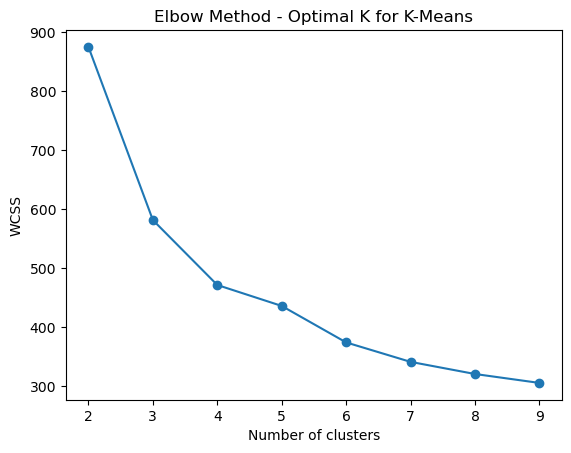

In [200]:

# Elbow method to find optimal K
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title("Elbow Method - Optimal K for K-Means")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
# plt.grid(True)
plt.show()

In [67]:
optimal_k_list = [3,4,5,6]
for optimal_k in optimal_k_list:
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(X_preprocessed)
    evaluate_clustering(X_preprocessed, clusters, f"K-Means: {optimal_k}")

--- K-Means: 3 ---
Clusters: 3
Silhouette Score: 0.657
Calinski-Harabasz Score: 5662.970
Davies-Bouldin Score: 0.666

--- K-Means: 4 ---
Clusters: 4
Silhouette Score: 0.601
Calinski-Harabasz Score: 4794.394
Davies-Bouldin Score: 0.867

--- K-Means: 5 ---
Clusters: 5
Silhouette Score: 0.588
Calinski-Harabasz Score: 3922.968
Davies-Bouldin Score: 1.003

--- K-Means: 6 ---
Clusters: 6
Silhouette Score: 0.447
Calinski-Harabasz Score: 3714.324
Davies-Bouldin Score: 1.119



In [68]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmean_clusters = kmeans.fit_predict(X_preprocessed)

crime_house_stats_pivot['k_mean_3_cluster'] = kmean_clusters

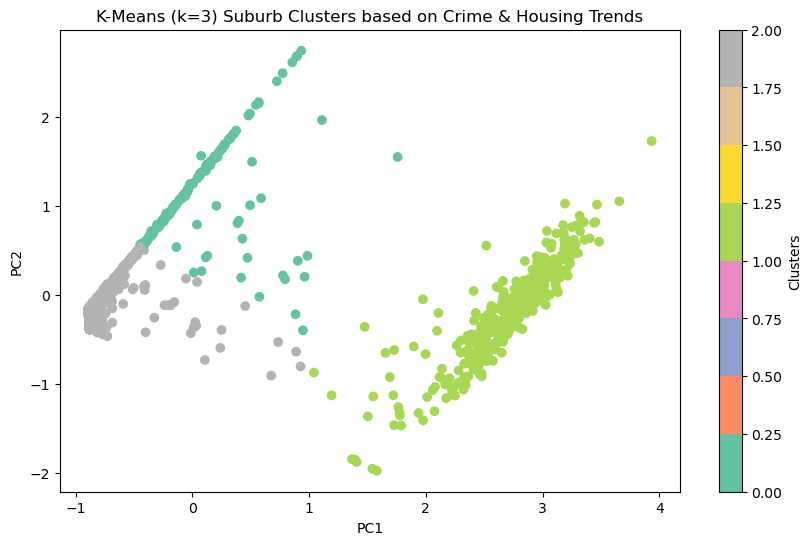

In [69]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=kmean_clusters, cmap='Set2')
plt.title(f"K-Means (k={optimal_k}) Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Clusters')
plt.show()

In [70]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmean_clusters = kmeans.fit_predict(X_preprocessed)

crime_house_stats_pivot['k_mean_4_cluster'] = kmean_clusters
# flat_features['suburb'] = flat_features.index

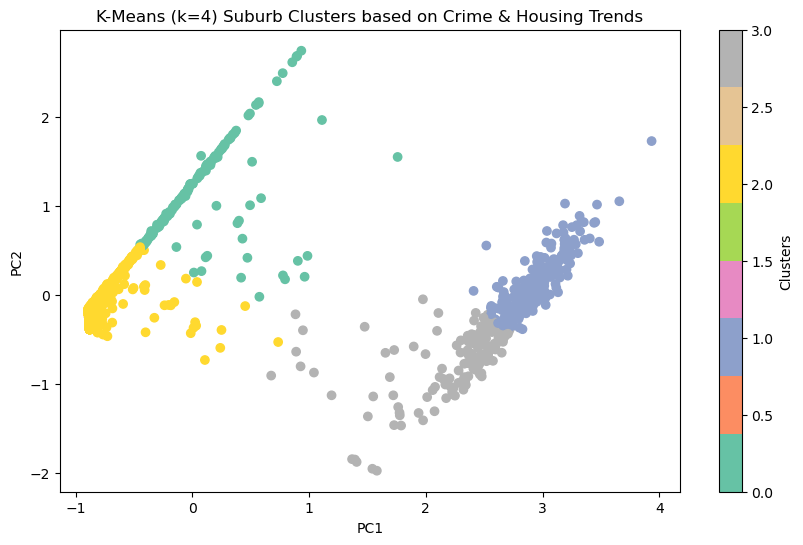

In [71]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=kmean_clusters, cmap='Set2')
plt.title(f"K-Means (k={optimal_k}) Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Clusters')
plt.show()

# DBSCAN Cluster

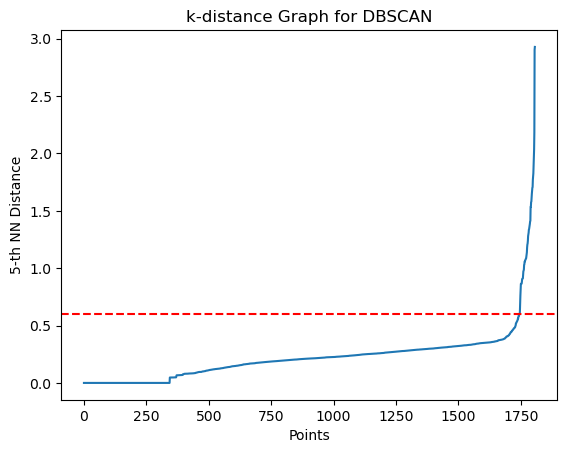

In [72]:
# Fit Nearest Neighbors
k = 5  # usually min_samples
nn = NearestNeighbors(n_neighbors=k)
nn_fit = nn.fit(X_preprocessed)
distances, indices = nn_fit.kneighbors(X_preprocessed)

# Sort distances and plot
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.axhline(y=0.6, color='r', linestyle='--')  # you may adjust this line
plt.title("k-distance Graph for DBSCAN")
plt.xlabel("Points")
plt.ylabel(f"{k}-th NN Distance")
# plt.grid(True)
plt.show()


In [73]:
for eps in [0.4, 0.5, 0.6, 0.7]:
    for min_samples in [3, 5, 8]:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_preprocessed)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps={eps}, min_samples={min_samples}: Number of clusters = {n_clusters}")
        if n_clusters > 1:
            # evaluate_clustering(X_preprocessed, labels, f"DBSCAN - eps: {eps}, min_sample: {min_samples}")
            sil = silhouette_score(X_preprocessed, labels)
            ch = calinski_harabasz_score(X_preprocessed, labels)
            db = davies_bouldin_score(X_preprocessed, labels)
            print(f"silhouette={sil:.3f}, CH score={ch:.3f}, DB score={db:.3f}")
        else:
            print(f"Only one cluster or all noise")

eps=0.4, min_samples=3: Number of clusters = 5
silhouette=0.544, CH score=1450.405, DB score=1.198
eps=0.4, min_samples=5: Number of clusters = 3
silhouette=0.665, CH score=2366.689, DB score=1.182
eps=0.4, min_samples=8: Number of clusters = 2
silhouette=0.679, CH score=3446.105, DB score=1.278
eps=0.5, min_samples=3: Number of clusters = 6
silhouette=0.553, CH score=1272.367, DB score=1.285
eps=0.5, min_samples=5: Number of clusters = 4
silhouette=0.637, CH score=1879.643, DB score=1.200
eps=0.5, min_samples=8: Number of clusters = 2
silhouette=0.683, CH score=3602.531, DB score=1.284
eps=0.6, min_samples=3: Number of clusters = 5
silhouette=0.580, CH score=1541.687, DB score=1.347
eps=0.6, min_samples=5: Number of clusters = 5
silhouette=0.583, CH score=1536.697, DB score=1.347
eps=0.6, min_samples=8: Number of clusters = 2
silhouette=0.680, CH score=3601.135, DB score=1.327
eps=0.7, min_samples=3: Number of clusters = 4
silhouette=0.594, CH score=1859.827, DB score=1.432
eps=0.7, m

In [155]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_preprocessed)
crime_house_stats_pivot['dbscan_e6_m5_cluster'] = dbscan_labels

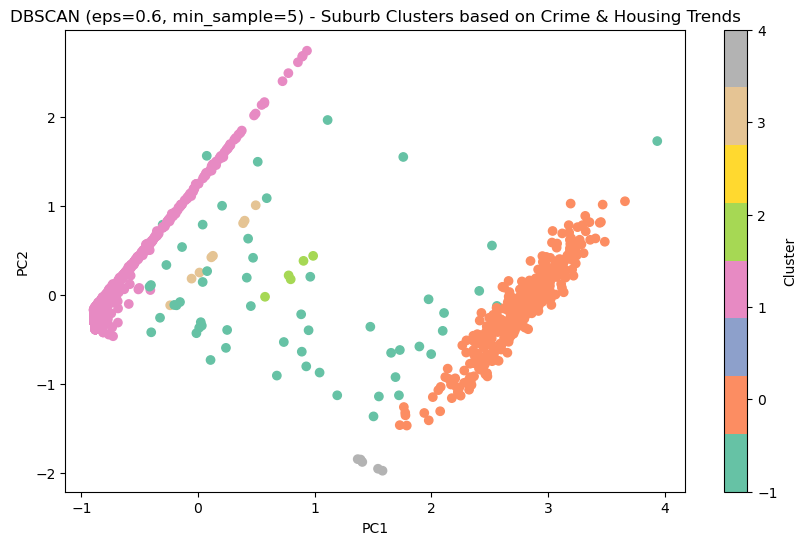

In [156]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='Set2')
plt.title(f"DBSCAN (eps=0.6, min_sample=5) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [141]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_preprocessed)

# crime_house_stats_pivot['dbscan_e4_m5_cluster'] = dbscan_labels

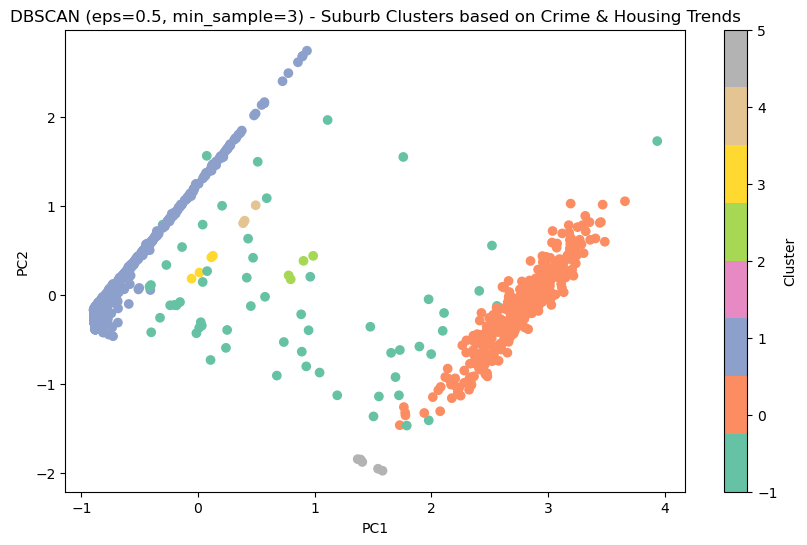

In [142]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='Set2')
plt.title(f"DBSCAN (eps=0.5, min_sample=3) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [111]:
dbscan = DBSCAN(eps=0.4, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_preprocessed)

crime_house_stats_pivot['dbscan_e4_m5_cluster'] = dbscan_labels

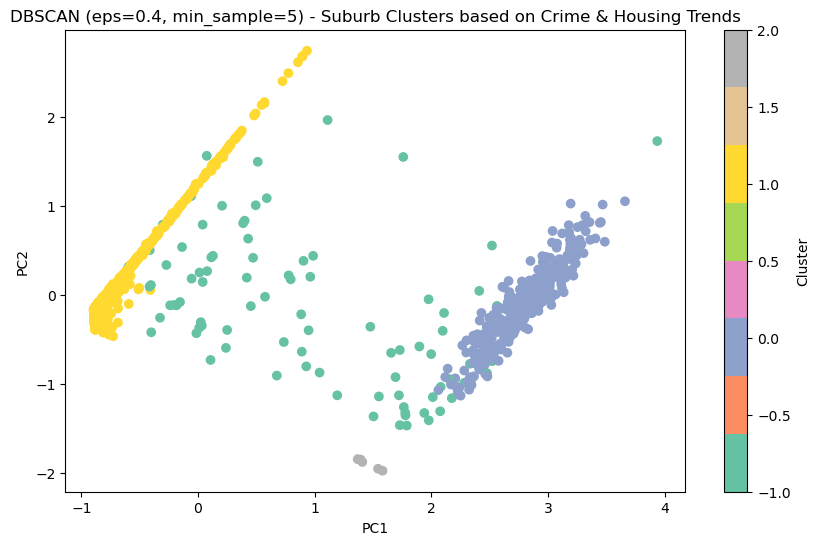

In [112]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='Set2')
plt.title(f"DBSCAN (eps=0.4, min_sample=5) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [113]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_preprocessed)

crime_house_stats_pivot['dbscan_e5_m5_cluster'] = dbscan_labels

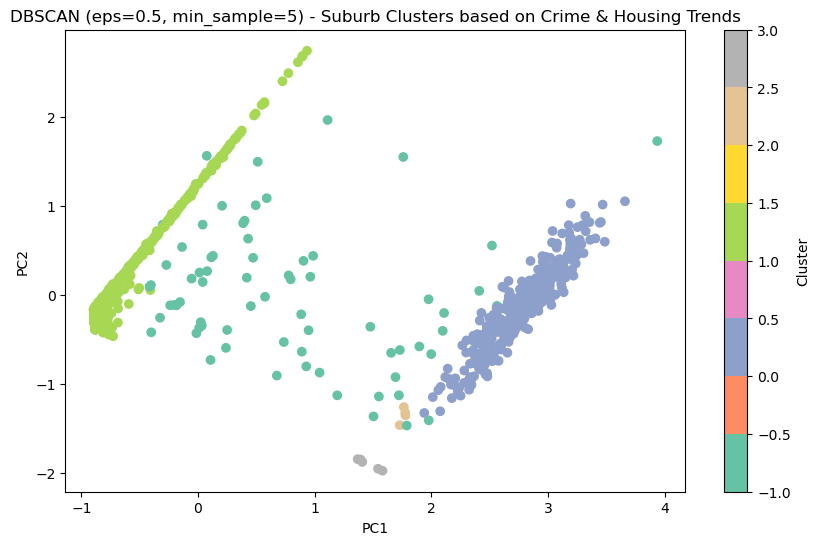

In [114]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='Set2')
plt.title("DBSCAN (eps=0.5, min_sample=5) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [115]:
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_preprocessed)

crime_house_stats_pivot['dbscan_e7_m5_cluster'] = dbscan_labels

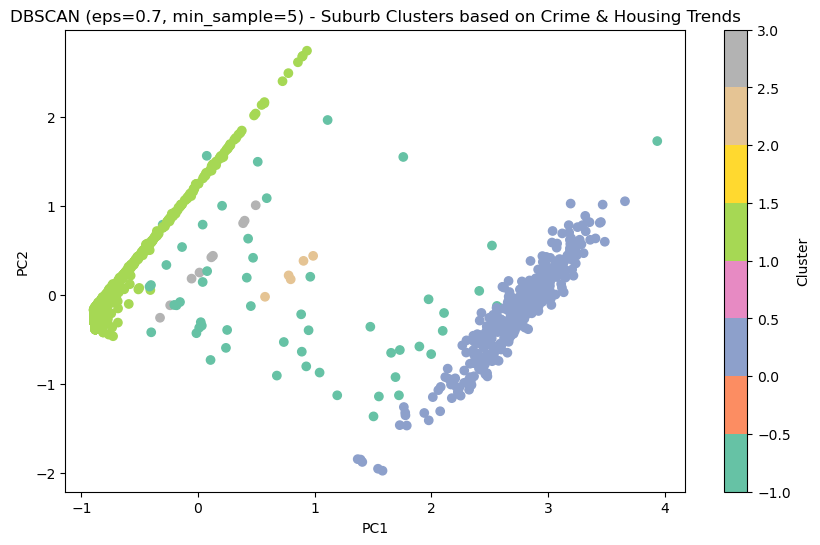

In [116]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='Set2')
plt.title("DBSCAN (eps=0.7, min_sample=5) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

# Agglomerative Clustering 

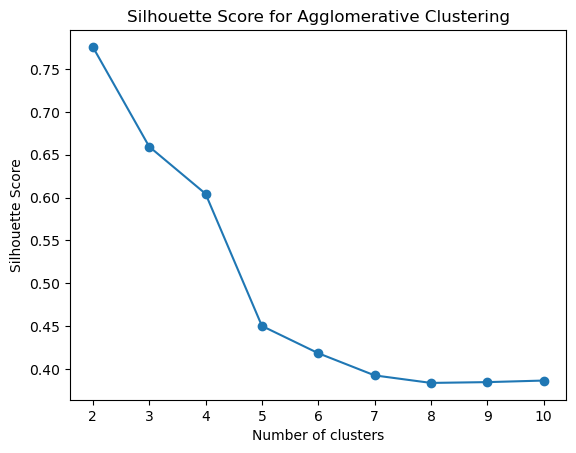

Optimal number of clusters based on silhouette: 2


In [83]:
sil_scores = []
k_range = range(2, 11)  # test from 2 to 10 clusters

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_preprocessed)
    score = silhouette_score(X_preprocessed, labels)
    sil_scores.append(score)

# Plotting silhouette scores
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score for Agglomerative Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
# plt.grid(True)
plt.show()

optimal_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters based on silhouette: {optimal_k}")

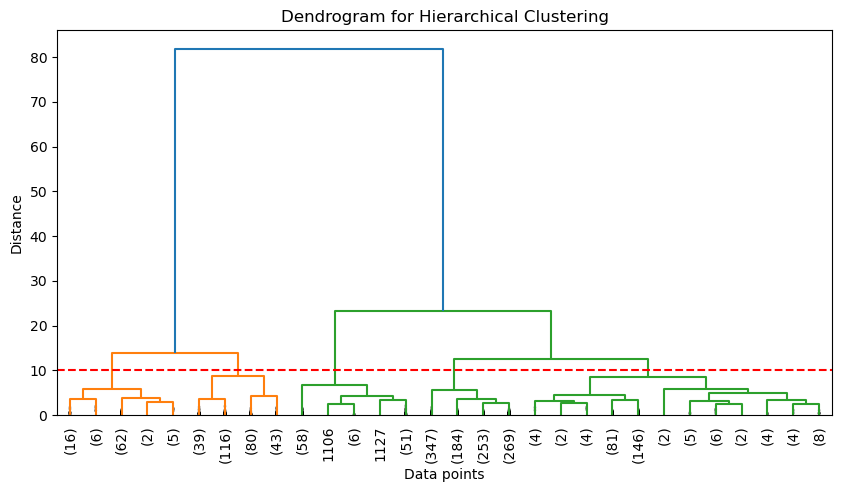

In [84]:
Z = linkage(X_preprocessed, method='ward')  # 'ward' minimizes variance
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.axhline(y=10, color='r', linestyle='--')  # adjust based on where you see big vertical jumps
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.show()

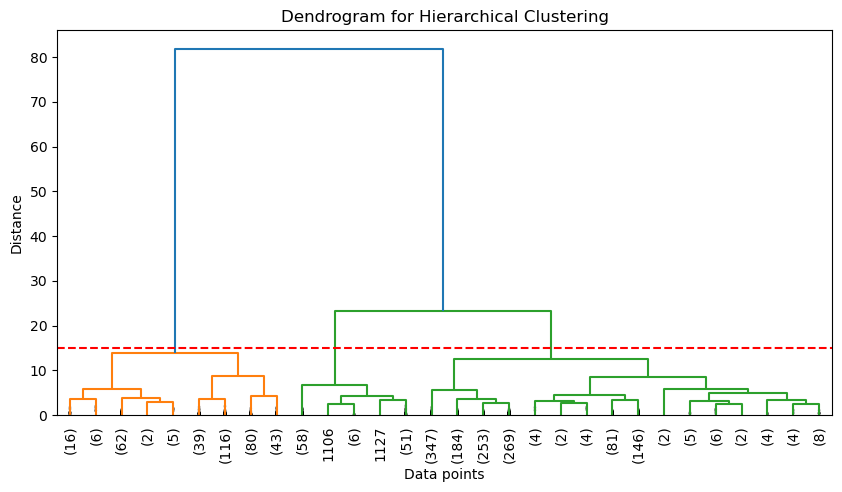

In [53]:
Z = linkage(X_preprocessed, method='ward')  # 'ward' minimizes variance
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.axhline(y=15, color='r', linestyle='--')  # adjust based on where you see big vertical jumps
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.show()

In [85]:
optimal_k_list = [3,4,5,6,7]
for optimal_k in optimal_k_list:
    agglo = AgglomerativeClustering(n_clusters=optimal_k)
    clusters = agglo.fit_predict(X_preprocessed)
    evaluate_clustering(X_preprocessed, clusters, f"Agglomerative: {optimal_k}")

--- Agglomerative: 3 ---
Clusters: 3
Silhouette Score: 0.659
Calinski-Harabasz Score: 5336.091
Davies-Bouldin Score: 0.548

--- Agglomerative: 4 ---
Clusters: 4
Silhouette Score: 0.604
Calinski-Harabasz Score: 4346.696
Davies-Bouldin Score: 0.811

--- Agglomerative: 5 ---
Clusters: 5
Silhouette Score: 0.450
Calinski-Harabasz Score: 3920.592
Davies-Bouldin Score: 1.159

--- Agglomerative: 6 ---
Clusters: 6
Silhouette Score: 0.418
Calinski-Harabasz Score: 3466.192
Davies-Bouldin Score: 1.215

--- Agglomerative: 7 ---
Clusters: 7
Silhouette Score: 0.392
Calinski-Harabasz Score: 3202.230
Davies-Bouldin Score: 1.290



In [118]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_preprocessed)
crime_house_stats_pivot['agglo_3_cluster'] = agglo_labels

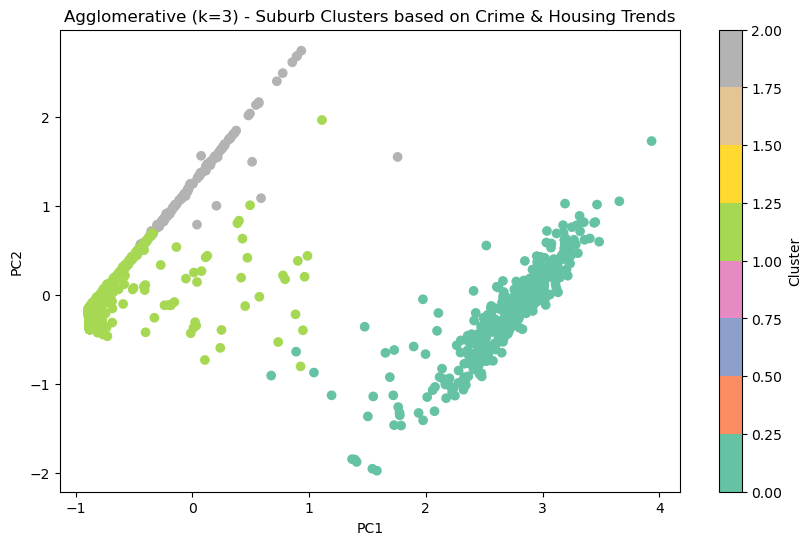

In [119]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=agglo_labels, cmap='Set2')
plt.title("Agglomerative (k=3) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [120]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_preprocessed)
crime_house_stats_pivot['agglo_4_cluster'] = agglo_labels

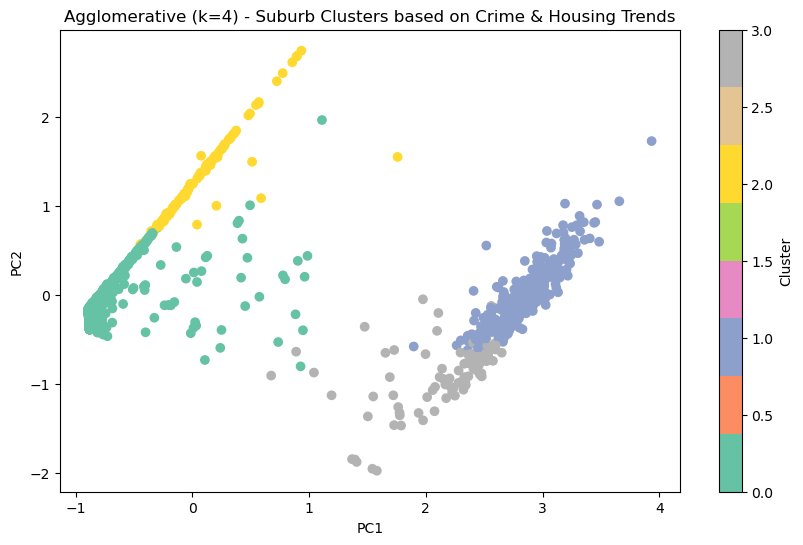

In [121]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=agglo_labels, cmap='Set2')
plt.title("Agglomerative (k=4) - Suburb Clusters based on Crime & Housing Trends")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

# Performance Comparison

In [148]:
crime_house_stats_pivot.columns

Index(['suburb', 'crime_againts_person_2015', 'crime_againts_person_2016',
       'crime_againts_person_2017', 'crime_againts_person_2018',
       'crime_againts_person_2019', 'crime_againts_person_2020',
       'crime_againts_person_2021', 'crime_againts_person_2022',
       'crime_againts_person_2023', 'crime_againts_person_2024',
       'crime_againts_property_2015', 'crime_againts_property_2016',
       'crime_againts_property_2017', 'crime_againts_property_2018',
       'crime_againts_property_2019', 'crime_againts_property_2020',
       'crime_againts_property_2021', 'crime_againts_property_2022',
       'crime_againts_property_2023', 'crime_againts_property_2024',
       'median_2015', 'median_2016', 'median_2017', 'median_2018',
       'median_2019', 'median_2020', 'median_2021', 'median_2022',
       'median_2023', 'median_2024', 'sales_2015', 'sales_2016', 'sales_2017',
       'sales_2018', 'sales_2019', 'sales_2020', 'sales_2021', 'sales_2022',
       'sales_2023', 'sales_20

In [149]:
# Evaluate
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['k_mean_3_cluster'], "K-Means: 3 Clusters")
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['dbscan_e5_m5_cluster'], "DBSCAN: 3 Clusters")
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['agglo_3_cluster'], "Agglomerative: 3 Clusters")

--- K-Means: 3 Clusters ---
Clusters: 3
Silhouette Score: 0.657
Calinski-Harabasz Score: 5662.970
Davies-Bouldin Score: 0.666

--- DBSCAN: 3 Clusters ---
Clusters: 5
Silhouette Score: 0.637
Calinski-Harabasz Score: 1879.643
Davies-Bouldin Score: 1.200

--- Agglomerative: 3 Clusters ---
Clusters: 3
Silhouette Score: 0.659
Calinski-Harabasz Score: 5336.091
Davies-Bouldin Score: 0.548



In [192]:
# Evaluate
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['k_mean_4_cluster'], "K-Means: 4 Clusters")
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['dbscan_e4_m5_cluster'], "DBSCAN: 3 Clusters")
evaluate_clustering(X_preprocessed, crime_house_stats_pivot['agglo_4_cluster'], "Agglomerative: 4 Clusters")

--- K-Means: 4 Clusters ---
Clusters: 4
Silhouette Score: 0.601
Calinski-Harabasz Score: 4794.394
Davies-Bouldin Score: 0.867

--- DBSCAN: 3 Clusters ---
Clusters: 4
Silhouette Score: 0.665
Calinski-Harabasz Score: 2366.689
Davies-Bouldin Score: 1.182

--- Agglomerative: 4 Clusters ---
Clusters: 4
Silhouette Score: 0.604
Calinski-Harabasz Score: 4346.696
Davies-Bouldin Score: 0.811



# Profiling

In [158]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11769 entries, 0 to 11768
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    11769 non-null  int64  
 1   suburb                  11769 non-null  object 
 2   crime_againts_property  11769 non-null  float64
 3   crime_againts_person    11769 non-null  float64
 4   sales                   11769 non-null  float64
 5   median                  11769 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 551.8+ KB


In [159]:
merged_df.head()

year            suburb  crime_againts_property  crime_againts_person  \
0  2015    ABERFOYLE PARK                   250.0                  78.0   
1  2015          ADELAIDE                  3918.0                1513.0   
2  2015  ADELAIDE AIRPORT                   162.0                  17.0   
3  2015          ALAWOONA                     2.0                   0.0   
4  2015       ALBERT PARK                   101.0                  12.0   

   sales    median  
0  143.0  411562.5  
1   25.0  615625.0  
2    0.0       0.0  
3    0.0       0.0  
4   28.0  411187.5

In [160]:
crime_house_stats_pivot.reset_index(inplace=True)
crime_house_stats_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        1807 non-null   int64  
 1   suburb                       1807 non-null   object 
 2   crime_againts_person_2015    1807 non-null   float64
 3   crime_againts_person_2016    1807 non-null   float64
 4   crime_againts_person_2017    1807 non-null   float64
 5   crime_againts_person_2018    1807 non-null   float64
 6   crime_againts_person_2019    1807 non-null   float64
 7   crime_againts_person_2020    1807 non-null   float64
 8   crime_againts_person_2021    1807 non-null   float64
 9   crime_againts_person_2022    1807 non-null   float64
 10  crime_againts_person_2023    1807 non-null   float64
 11  crime_againts_person_2024    1807 non-null   float64
 12  crime_againts_property_2015  1807 non-null   float64
 13  crime_againts_prop

In [161]:
crime_house_stats_pivot['suburb'].nunique()

1807

In [162]:
clusters = [col for col in crime_house_stats_pivot.columns if col.endswith("cluster")]
clusters

['k_mean_3_cluster',
 'k_mean_4_cluster',
 'dbscan_e5_m5_cluster',
 'dbscan_e7_m5_cluster',
 'dbscan_e4_m5_cluster',
 'agglo_3_cluster',
 'agglo_4_cluster',
 'dbscan_e6_m5_cluster']

In [163]:
df_clusters = crime_house_stats_pivot[['suburb']+clusters]
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   suburb                1807 non-null   object
 1   k_mean_3_cluster      1807 non-null   int32 
 2   k_mean_4_cluster      1807 non-null   int32 
 3   dbscan_e5_m5_cluster  1807 non-null   int64 
 4   dbscan_e7_m5_cluster  1807 non-null   int64 
 5   dbscan_e4_m5_cluster  1807 non-null   int64 
 6   agglo_3_cluster       1807 non-null   int64 
 7   agglo_4_cluster       1807 non-null   int64 
 8   dbscan_e6_m5_cluster  1807 non-null   int64 
dtypes: int32(2), int64(6), object(1)
memory usage: 113.1+ KB


In [164]:
# Merge cluster labels into original dataframe
df_profiled = df_clusters.merge(merged_df, on='suburb', how='left')

df_profiled_2024 = df_profiled[df_profiled['year'] == 2024]

In [104]:
kmean_3_cluster_summary = df_profiled_2024.groupby('k_mean_3_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

kmean_3_cluster_summary

crime_againts_property                      \
                                   mean median  min     max   
k_mean_3_cluster                                              
0                             56.750000   20.5  0.0  1016.0   
1                             94.856354   59.5  1.0  3048.0   
2                              2.457031    1.0  0.0    34.0   

                 crime_againts_person                          sales         \
                                 mean median  min     max       mean median   
k_mean_3_cluster                                                              
0                           29.676829    7.0  0.0  1154.0   0.817073    0.0   
1                           25.837017   13.0  0.0  1101.0  51.143646   33.0   
2                            0.914062    0.0  0.0     8.0   0.191406    0.0   

                        median            num_suburbs  
                          mean     median       count  
k_mean_3_cluster                                       
0                 5.557161e+04       0.00         164  
1                 1.082369e+06  919718.75         362  
2                 1.490202e+04       0.00         512

In [133]:
135/1807

0.07470946319867183

In [105]:
kmean_4_cluster_summary = df_profiled_2024.groupby('k_mean_4_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

kmean_4_cluster_summary

crime_againts_property                       \
                                   mean median   min     max   
k_mean_4_cluster                                               
0                             57.527950   21.0   0.0  1016.0   
1                            134.331897   86.5  20.0  3048.0   
2                              2.427451    1.0   0.0    34.0   
3                             23.985185   20.0   1.0   103.0   

                 crime_againts_person                          sales         \
                                 mean median  min     max       mean median   
k_mean_4_cluster                                                              
0                           30.167702    7.0  0.0  1154.0   0.813665    0.0   
1                           37.672414   22.5  5.0  1101.0  69.150862   51.5   
2                            0.927451    0.0  0.0     8.0   0.078431    0.0   
3                            4.577778    4.0  0.0    24.0  18.755556   17.0   

                        median             num_suburbs  
                          mean      median       count  
k_mean_4_cluster                                        
0                 4.318164e+04        0.00         161  
1                 9.150051e+05   840343.75         232  
2                 1.338758e+04        0.00         510  
3                 1.351852e+06  1251000.00         135

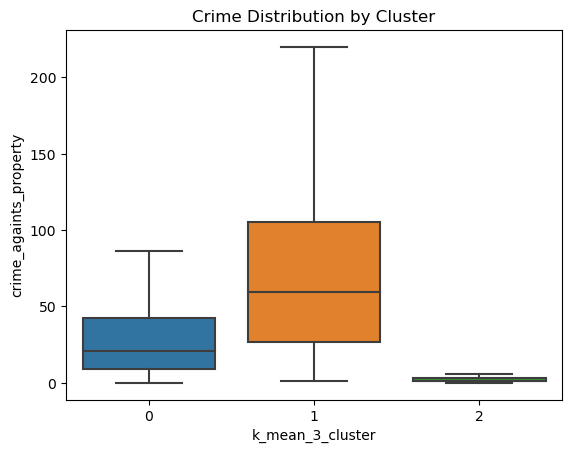

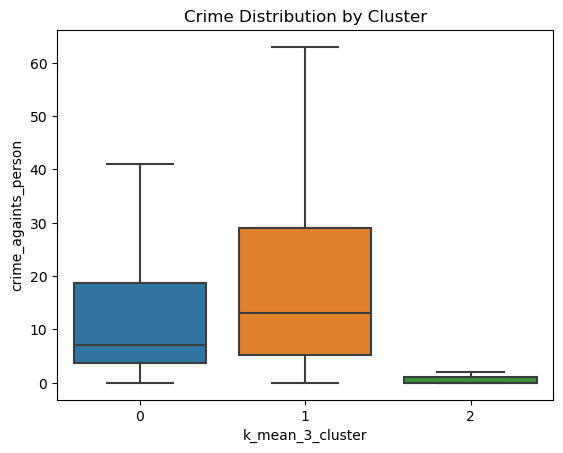

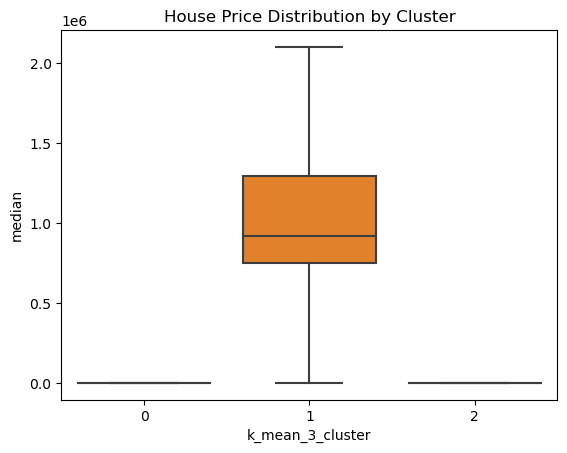

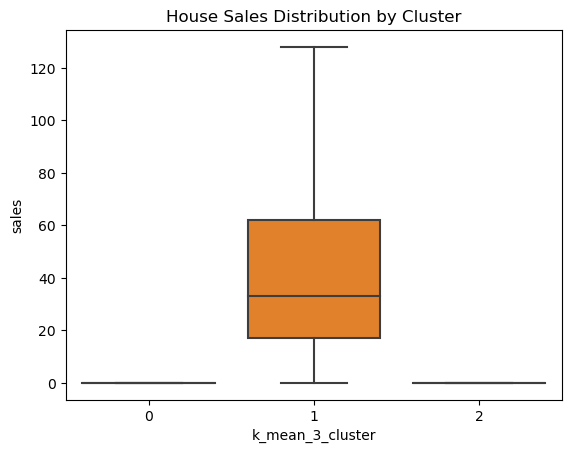

In [186]:
# Boxplot of crime by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_3_cluster', y='crime_againts_property', showfliers=False)
plt.title('Crime Distribution by Cluster')
plt.show()

sns.boxplot(data=df_profiled_2024, x='k_mean_3_cluster', y='crime_againts_person', showfliers=False)
plt.title('Crime Distribution by Cluster')
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_3_cluster', y='median', showfliers=False)
plt.title('House Price Distribution by Cluster')
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_3_cluster', y='sales', showfliers=False)
plt.title('House Sales Distribution by Cluster')
plt.show()

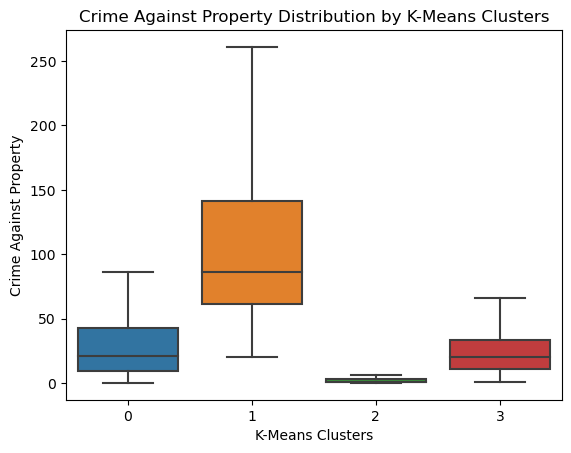

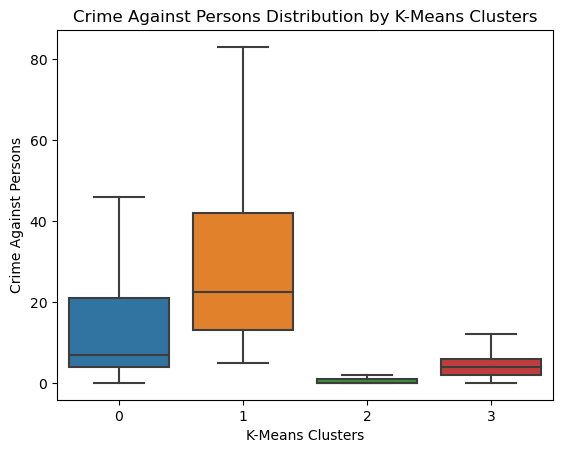

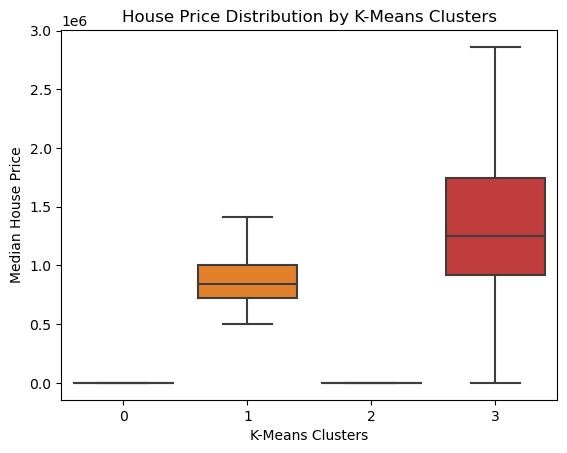

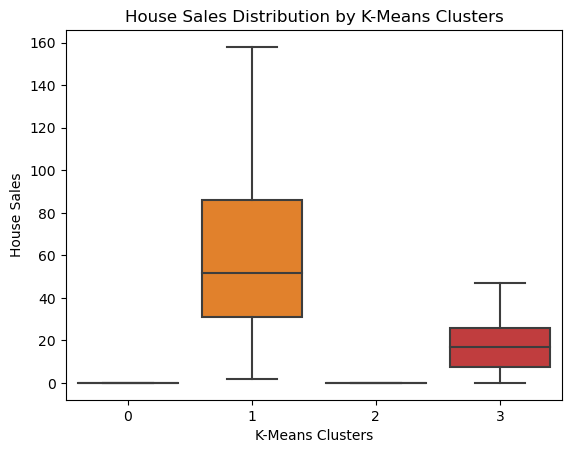

In [201]:
# Boxplot of crime by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_4_cluster', y='crime_againts_property', showfliers=False)
plt.title('Crime Against Property Distribution by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Crime Against Property")
plt.show()

sns.boxplot(data=df_profiled_2024, x='k_mean_4_cluster', y='crime_againts_person', showfliers=False)
plt.title('Crime Against Persons Distribution by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Crime Against Persons")
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_4_cluster', y='median', showfliers=False)
plt.title('House Price Distribution by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Median House Price")
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='k_mean_4_cluster', y='sales', showfliers=False)
plt.title('House Sales Distribution by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("House Sales")
plt.show()

In [181]:
df_profiled.columns

Index(['suburb', 'k_mean_3_cluster', 'k_mean_4_cluster',
       'dbscan_e5_m5_cluster', 'dbscan_e7_m5_cluster', 'dbscan_e4_m5_cluster',
       'agglo_3_cluster', 'agglo_4_cluster', 'dbscan_e6_m5_cluster', 'year',
       'crime_againts_property', 'crime_againts_person', 'sales', 'median'],
      dtype='object')

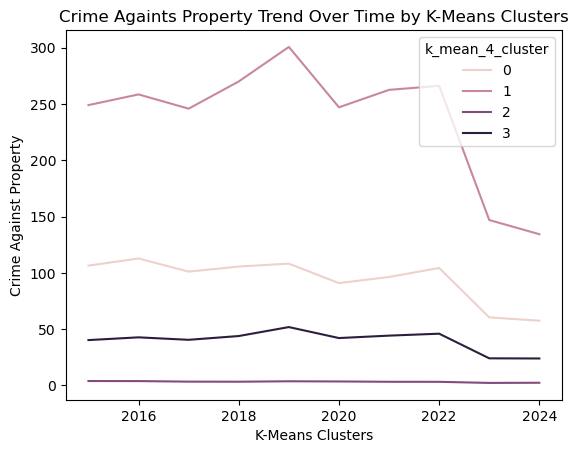

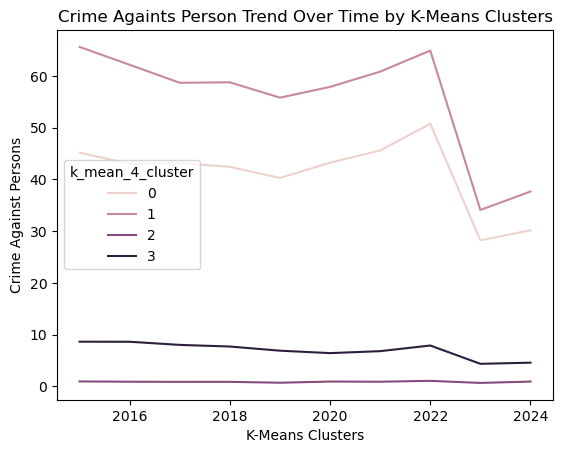

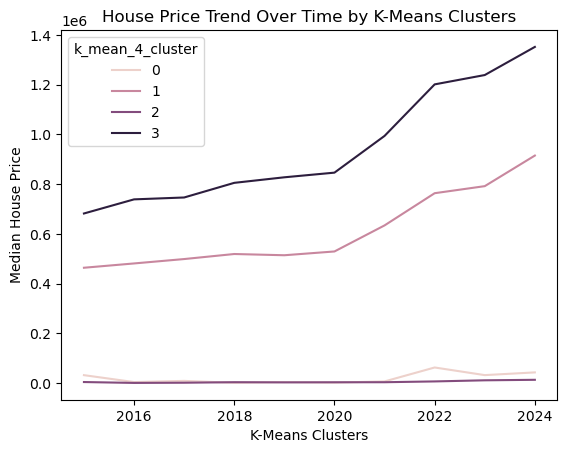

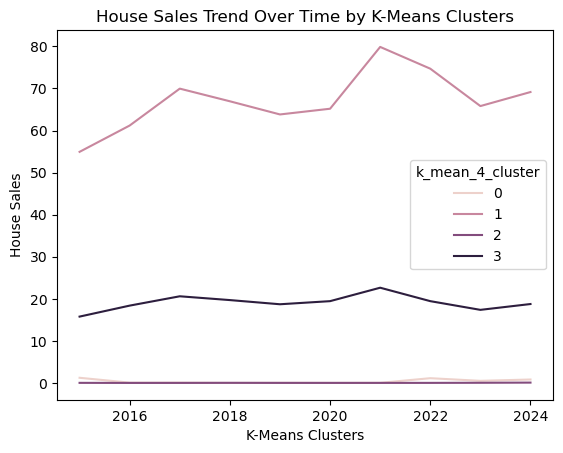

In [202]:
# Lineplot of average crime over time per cluster
# df_profiled['date'] = pd.to_datetime(df_profiled['year'])

trend = df_profiled.groupby(['year', 'k_mean_4_cluster'])['crime_againts_property'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_property', hue='k_mean_4_cluster')
plt.title('Crime Againts Property Trend Over Time by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Crime Against Property")
plt.show()

trend = df_profiled.groupby(['year', 'k_mean_4_cluster'])['crime_againts_person'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_person', hue='k_mean_4_cluster')
plt.title('Crime Againts Person Trend Over Time by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Crime Against Persons")
plt.show()

trend = df_profiled.groupby(['year', 'k_mean_4_cluster'])['median'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='median', hue='k_mean_4_cluster')
plt.title('House Price Trend Over Time by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("Median House Price")
plt.show()

trend = df_profiled.groupby(['year', 'k_mean_4_cluster'])['sales'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='sales', hue='k_mean_4_cluster')
plt.title('House Sales Trend Over Time by K-Means Clusters')
plt.xlabel("K-Means Clusters")
plt.ylabel("House Sales")
plt.show()

In [135]:
df_profiled_2023 = df_profiled[df_profiled['year'] == 2023]

In [136]:
kmean_4_cluster_2023_summary = df_profiled_2023.groupby('k_mean_4_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean'],
    'median': ['mean'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

kmean_4_cluster_2023_summary

crime_againts_property                       \
                                   mean median   min     max   
k_mean_4_cluster                                               
0                             60.484472   18.0   0.0  1010.0   
1                            146.909483   98.0  18.0  3298.0   
2                              2.278598    1.0   0.0    26.0   
3                             24.111111   21.0   0.0    86.0   

                 crime_againts_person                          sales  \
                                 mean median  min     max       mean   
k_mean_4_cluster                                                       
0                           28.242236    6.0  0.0  1268.0   0.496894   
1                           34.107759   19.5  2.0   935.0  65.814655   
2                            0.662362    0.0  0.0     7.0   0.036900   
3                            4.355556    3.0  0.0    17.0  17.370370   

                        median num_suburbs  
                          mean       count  
k_mean_4_cluster                            
0                 3.224079e+04         161  
1                 7.920440e+05         232  
2                 1.134502e+04         542  
3                 1.238800e+06         135

In [151]:
dbscane_e4_m5_3_cluster_summary = df_profiled_2024.groupby('dbscan_e4_m5_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

dbscane_e4_m5_3_cluster_summary

crime_againts_property                      \
                                       mean median  min     max   
dbscan_e4_m5_cluster                                              
-1                                61.943182    7.0  0.0  3048.0   
 0                                92.788344   64.0  4.0   704.0   
 1                                14.748397    2.0  0.0  1016.0   

                     crime_againts_person                          sales  \
                                     mean median  min     max       mean   
dbscan_e4_m5_cluster                                                       
-1                              31.840909    2.0  0.0  1154.0  11.465909   
 0                              24.803681   14.0  0.0   181.0  54.407975   
 1                               6.089744    1.0  0.0   436.0   0.000000   

                                   median            num_suburbs  
                     median          mean     median       count  
dbscan_e4_m5_cluster                                              
-1                      2.0  6.816374e+05  694625.00          88  
 0                     36.0  1.069254e+06  911218.75         326  
 1                      0.0  0.000000e+00       0.00         624

In [152]:
dbscane_e5_m5_4_cluster_summary = df_profiled_2024.groupby('dbscan_e5_m5_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

dbscane_e5_m5_4_cluster_summary

crime_againts_property                      \
                                       mean median  min     max   
dbscan_e5_m5_cluster                                              
-1                                72.492754    7.0  0.0  3048.0   
 0                                90.556213   62.5  1.0   704.0   
 1                                14.810207    2.0  0.0  1016.0   
 2                                 1.750000    2.0  1.0     2.0   

                     crime_againts_person                          sales  \
                                     mean median  min     max       mean   
dbscan_e5_m5_cluster                                                       
-1                              39.637681    2.0  0.0  1154.0   8.318841   
 0                              24.059172   13.5  0.0   181.0  53.713018   
 1                               6.081340    1.0  0.0   436.0   0.000000   
 2                               2.000000    2.0  1.0     3.0   4.250000   

                                   median               num_suburbs  
                     median          mean        median       count  
dbscan_e5_m5_cluster                                                 
-1                      1.0  5.195188e+05  5.150000e+05          69  
 0                     35.0  1.089926e+06  9.197188e+05         338  
 1                      0.0  0.000000e+00  0.000000e+00         627  
 2                      4.0  1.079833e+06  1.139667e+06           4

In [172]:
624/1807

0.34532374100719426

In [165]:
dbscane_e6_m5_5_cluster_summary = df_profiled_2024.groupby('dbscan_e6_m5_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean'],
    'median': ['mean'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

dbscane_e6_m5_5_cluster_summary

crime_againts_property                      \
                                       mean median  min     max   
dbscan_e6_m5_cluster                                              
-1                                89.759259    7.0  0.0  3048.0   
 0                                89.011628   61.0  1.0   704.0   
 1                                14.810207    2.0  0.0  1016.0   
 2                                15.000000   16.0  2.0    30.0   
 3                                 9.375000    7.0  2.0    25.0   

                     crime_againts_person                          sales  \
                                     mean median  min     max       mean   
dbscan_e6_m5_cluster                                                       
-1                              49.648148    2.0  0.0  1154.0   8.425926   
 0                              23.662791   13.0  0.0   181.0  52.845930   
 1                               6.081340    1.0  0.0   436.0   0.000000   
 2                               4.600000    5.0  0.0     9.0  22.400000   
 3                               3.875000    2.0  0.0    13.0   0.000000   

                            median num_suburbs  
                              mean       count  
dbscan_e6_m5_cluster                            
-1                    5.346106e+05          54  
 0                    1.093048e+06         344  
 1                    0.000000e+00         627  
 2                    7.366889e+05           5  
 3                    0.000000e+00           8

In [153]:
dbscane_e7_m5_4_cluster_summary = df_profiled_2024.groupby('dbscan_e7_m5_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

dbscane_e7_m5_4_cluster_summary

crime_againts_property                      \
                                       mean median  min     max   
dbscan_e7_m5_cluster                                              
-1                                91.452830    7.0  0.0  3048.0   
 0                                89.011628   61.0  1.0   704.0   
 1                                14.810207    2.0  0.0  1016.0   
 2                                15.000000   16.0  2.0    30.0   
 3                                 8.333333    7.0  0.0    25.0   

                     crime_againts_person                          sales  \
                                     mean median  min     max       mean   
dbscan_e7_m5_cluster                                                       
-1                              50.547170    2.0  0.0  1154.0   8.584906   
 0                              23.662791   13.0  0.0   181.0  52.845930   
 1                               6.081340    1.0  0.0   436.0   0.000000   
 2                               4.600000    5.0  0.0     9.0  22.400000   
 3                               3.666667    2.0  0.0    13.0   0.000000   

                                   median           num_suburbs  
                     median          mean    median       count  
dbscan_e7_m5_cluster                                             
-1                      1.0  5.446976e+05  524250.0          53  
 0                     34.0  1.093048e+06  925375.0         344  
 1                      0.0  0.000000e+00       0.0         627  
 2                     20.0  7.366889e+05  722500.0           5  
 3                      0.0  0.000000e+00       0.0           9

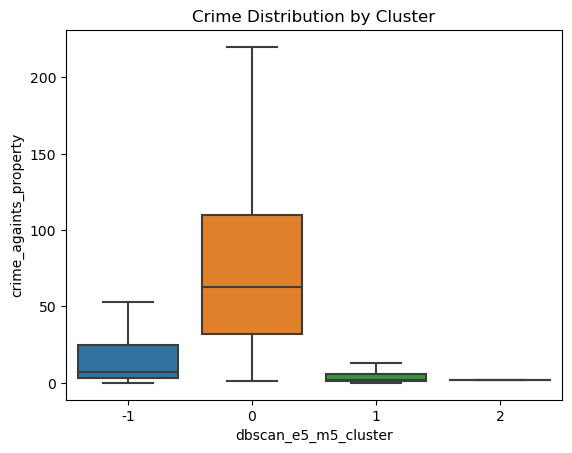

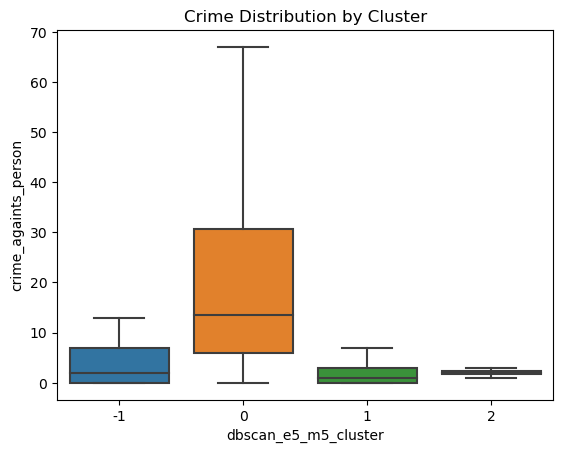

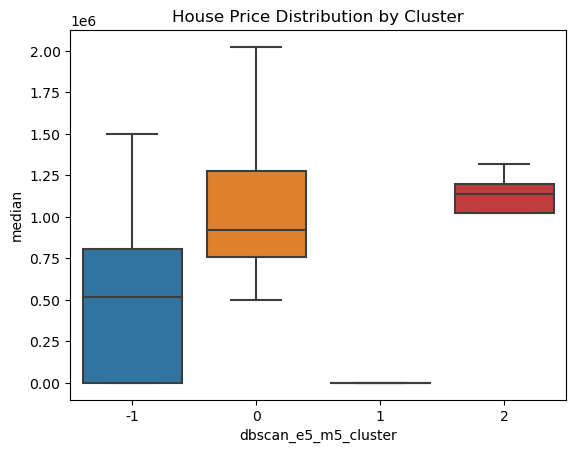

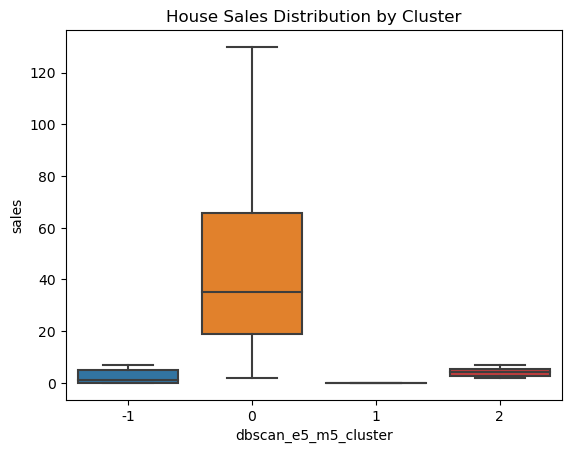

In [189]:
# Boxplot of crime by cluster
sns.boxplot(data=df_profiled_2024, x='dbscan_e5_m5_cluster', y='crime_againts_property', showfliers=False)
plt.title('Crime Distribution by Cluster')
plt.show()

sns.boxplot(data=df_profiled_2024, x='dbscan_e5_m5_cluster', y='crime_againts_person', showfliers=False)
plt.title('Crime Distribution by Cluster')
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='dbscan_e5_m5_cluster', y='median', showfliers=False)
plt.title('House Price Distribution by Cluster')
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='dbscan_e5_m5_cluster', y='sales', showfliers=False)
plt.title('House Sales Distribution by Cluster')
plt.show()

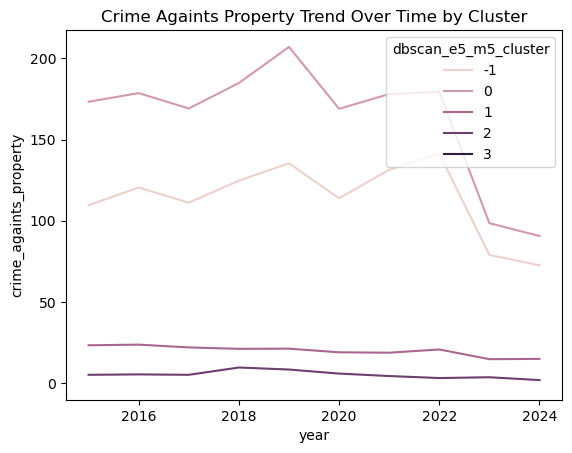

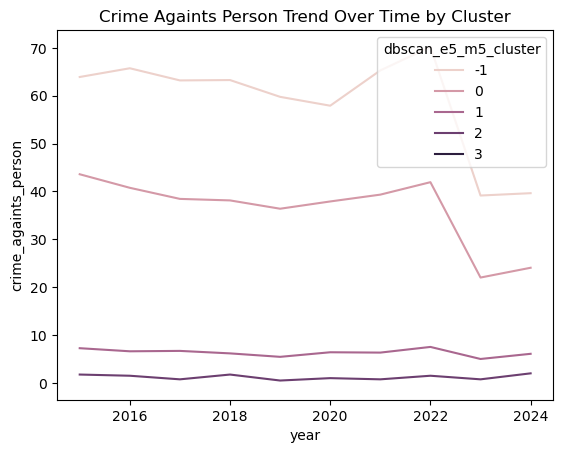

In [188]:

trend = df_profiled.groupby(['year', 'dbscan_e5_m5_cluster'])['crime_againts_property'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_property', hue='dbscan_e5_m5_cluster')
plt.title('Crime Againts Property Trend Over Time by Cluster')
plt.show()

trend = df_profiled.groupby(['year', 'dbscan_e5_m5_cluster'])['crime_againts_person'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_person', hue='dbscan_e5_m5_cluster')
plt.title('Crime Againts Person Trend Over Time by Cluster')
plt.show()

In [109]:
# Example: calculate summary statistics by cluster
agglo_3_cluster_summary = df_profiled_2024.groupby('agglo_3_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

agglo_3_cluster_summary

crime_againts_property                      \
                                  mean median  min     max   
agglo_3_cluster                                              
0                            94.354396   59.0  1.0  3048.0   
1                             3.658887    2.0  0.0   300.0   
2                            72.820513   27.0  0.0  1016.0   

                crime_againts_person                          sales         \
                                mean median  min     max       mean median   
agglo_3_cluster                                                              
0                          25.695055   13.0  0.0  1101.0  50.862637   33.0   
1                           1.274686    1.0  0.0    80.0   0.405745    0.0   
2                          39.529915   10.0  0.0  1154.0   0.051282    0.0   

                       median            num_suburbs  
                         mean     median       count  
agglo_3_cluster                                       
0                1.076422e+06  918781.25         364  
1                2.775777e+04       0.00         557  
2                1.096154e+04       0.00         117

In [178]:
86/1807

0.047592695074709465

In [110]:
agglo_4_cluster_summary = df_profiled_2024.groupby('agglo_4_cluster').agg({
    'crime_againts_property': ['mean', 'median', 'min', 'max'],
    'crime_againts_person': ['mean', 'median', 'min', 'max'],
    'sales': ['mean', 'median'],
    'median': ['mean', 'median'],
    'suburb': 'count'
}).rename(columns={'suburb': 'num_suburbs'})

agglo_4_cluster_summary

crime_againts_property                      \
                                  mean median  min     max   
agglo_4_cluster                                              
0                             3.658887    2.0  0.0   300.0   
1                           117.492806   75.5  9.0  3048.0   
2                            72.820513   27.0  0.0  1016.0   
3                            19.558140   15.0  1.0   113.0   

                crime_againts_person                          sales         \
                                mean median  min     max       mean median   
agglo_4_cluster                                                              
0                           1.274686    1.0  0.0    80.0   0.405745    0.0   
1                          32.658273   19.0  1.0  1101.0  60.089928   42.0   
2                          39.529915   10.0  0.0  1154.0   0.051282    0.0   
3                           3.186047    3.0  0.0    19.0  21.034884   17.0   

                       median            num_suburbs  
                         mean     median       count  
agglo_4_cluster                                       
0                2.775777e+04        0.0         557  
1                9.715634e+05   865875.0         278  
2                1.096154e+04        0.0         117  
3                1.415382e+06  1344250.0          86

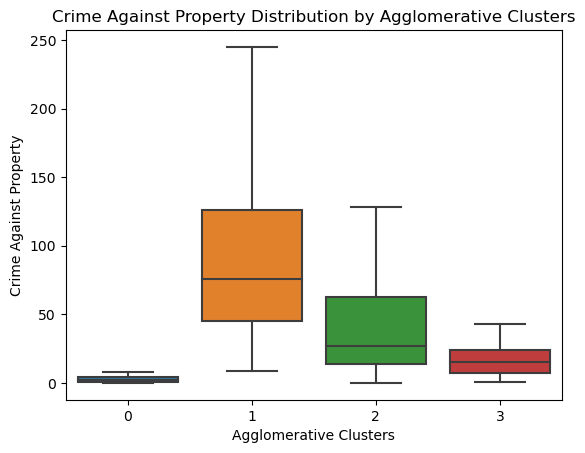

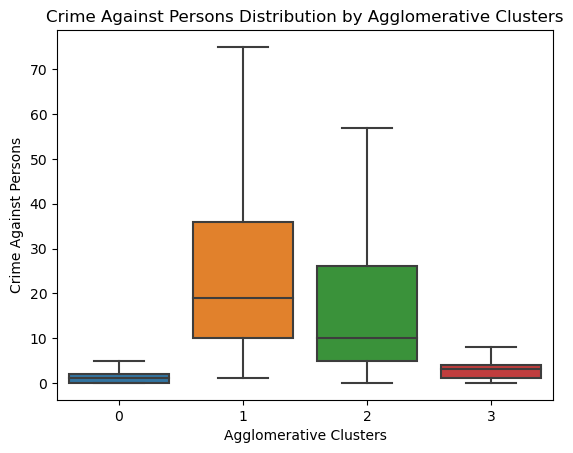

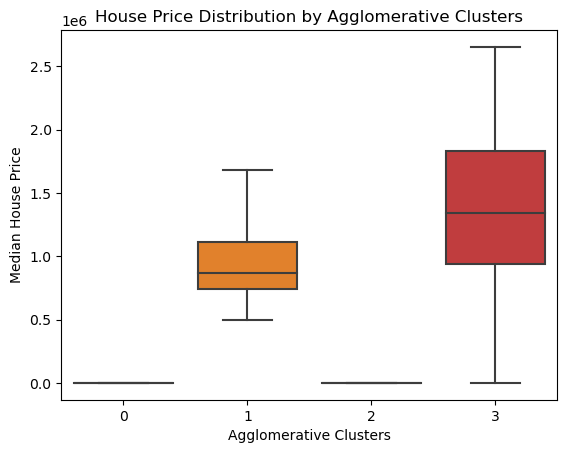

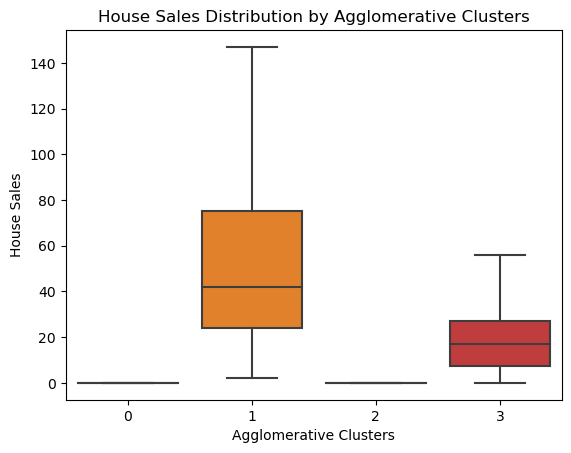

In [203]:
# Boxplot of crime by cluster
sns.boxplot(data=df_profiled_2024, x='agglo_4_cluster', y='crime_againts_property', showfliers=False)
plt.title('Crime Against Property Distribution by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Crime Against Property")
plt.show()

sns.boxplot(data=df_profiled_2024, x='agglo_4_cluster', y='crime_againts_person', showfliers=False)
plt.title('Crime Against Persons Distribution by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Crime Against Persons")
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='agglo_4_cluster', y='median', showfliers=False)
plt.title('House Price Distribution by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Median House Price")
plt.show()

# Boxplot of house price by cluster
sns.boxplot(data=df_profiled_2024, x='agglo_4_cluster', y='sales', showfliers=False)
plt.title('House Sales Distribution by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("House Sales")
plt.show()

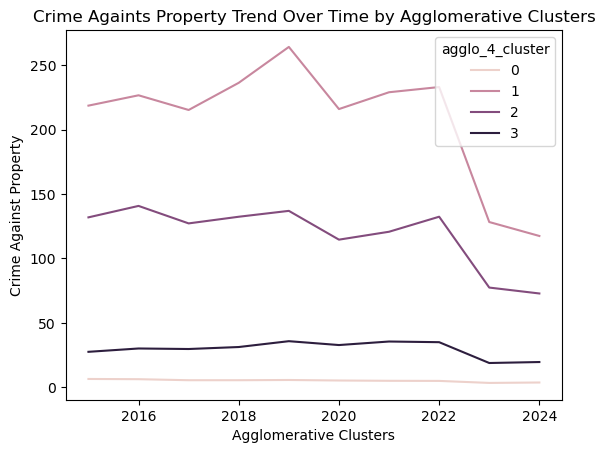

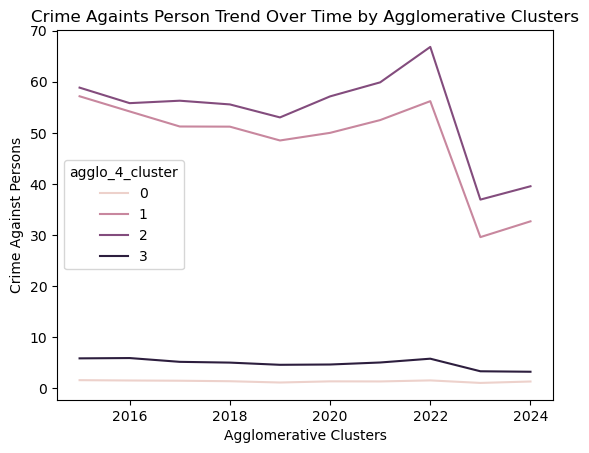

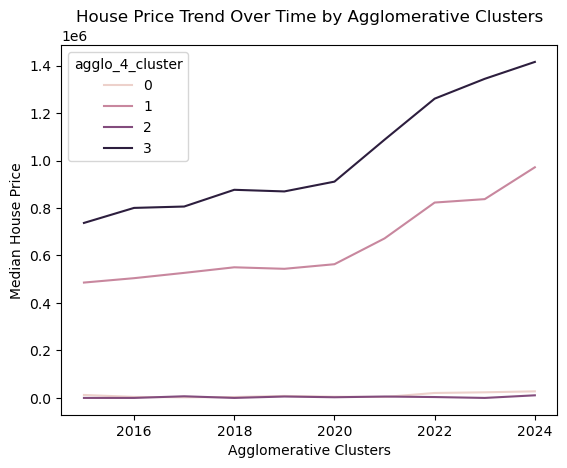

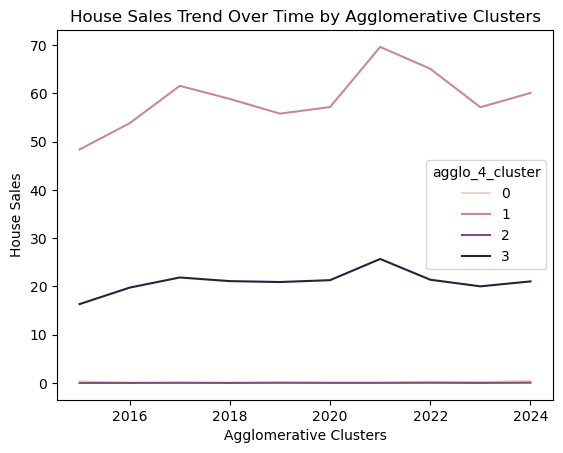

In [204]:
trend = df_profiled.groupby(['year', 'agglo_4_cluster'])['crime_againts_property'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_property', hue='agglo_4_cluster')
plt.title('Crime Againts Property Trend Over Time by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Crime Against Property")
plt.show()

trend = df_profiled.groupby(['year', 'agglo_4_cluster'])['crime_againts_person'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='crime_againts_person', hue='agglo_4_cluster')
plt.title('Crime Againts Person Trend Over Time by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Crime Against Persons")
plt.show()

trend = df_profiled.groupby(['year', 'agglo_4_cluster'])['median'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='median', hue='agglo_4_cluster')
plt.title('House Price Trend Over Time by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("Median House Price")
plt.show()

trend = df_profiled.groupby(['year', 'agglo_4_cluster'])['sales'].mean().reset_index()

sns.lineplot(data=trend, x='year', y='sales', hue='agglo_4_cluster')
plt.title('House Sales Trend Over Time by Agglomerative Clusters')
plt.xlabel("Agglomerative Clusters")
plt.ylabel("House Sales")
plt.show()

# Visualize suburb

In [193]:
gdf_clusters = gdf.merge(df_profiled, on=['suburb'], how="left")
gdf_clusters.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11817 entries, 0 to 11816
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   postcode                11817 non-null  object        
 1   suburb                  11817 non-null  object        
 2   suburb_num              11817 non-null  int32         
 3   legalstart              11675 non-null  datetime64[ms]
 4   shape_Leng              11817 non-null  float64       
 5   shape_Area              11817 non-null  float64       
 6   geometry                11817 non-null  geometry      
 7   k_mean_3_cluster        11548 non-null  float64       
 8   k_mean_4_cluster        11548 non-null  float64       
 9   dbscan_e5_m5_cluster    11548 non-null  float64       
 10  dbscan_e7_m5_cluster    11548 non-null  float64       
 11  dbscan_e4_m5_cluster    11548 non-null  float64       
 12  agglo_3_cluster         11548 non-null

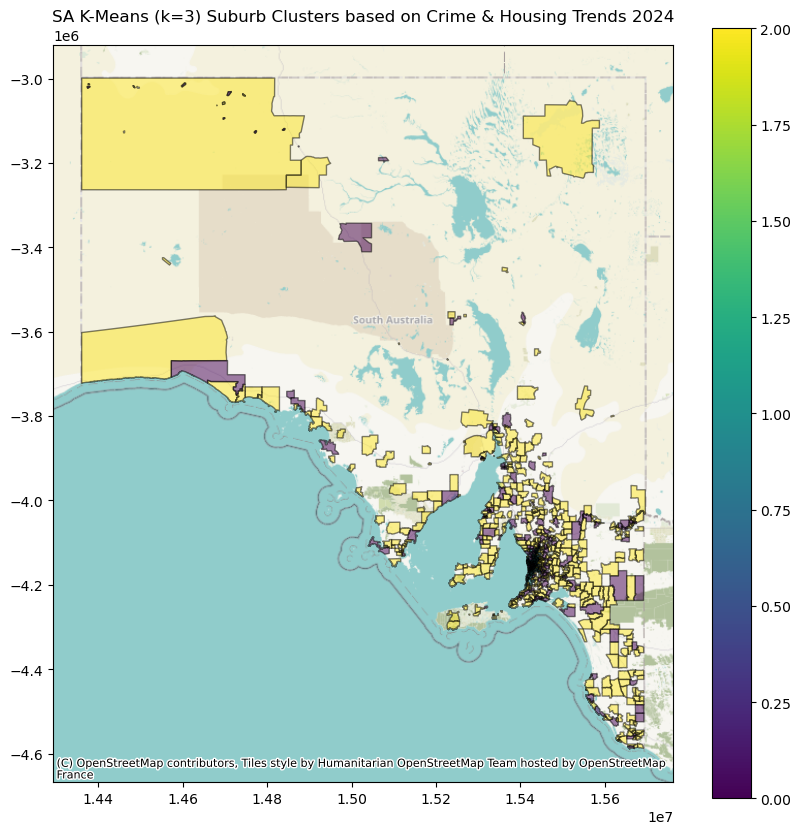

In [123]:
df_2024 = gdf_clusters.where(gdf_clusters['year'] == 2024).to_crs(epsg=3857)
ax = df_2024.plot(column='k_mean_3_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA K-Means (k=3) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

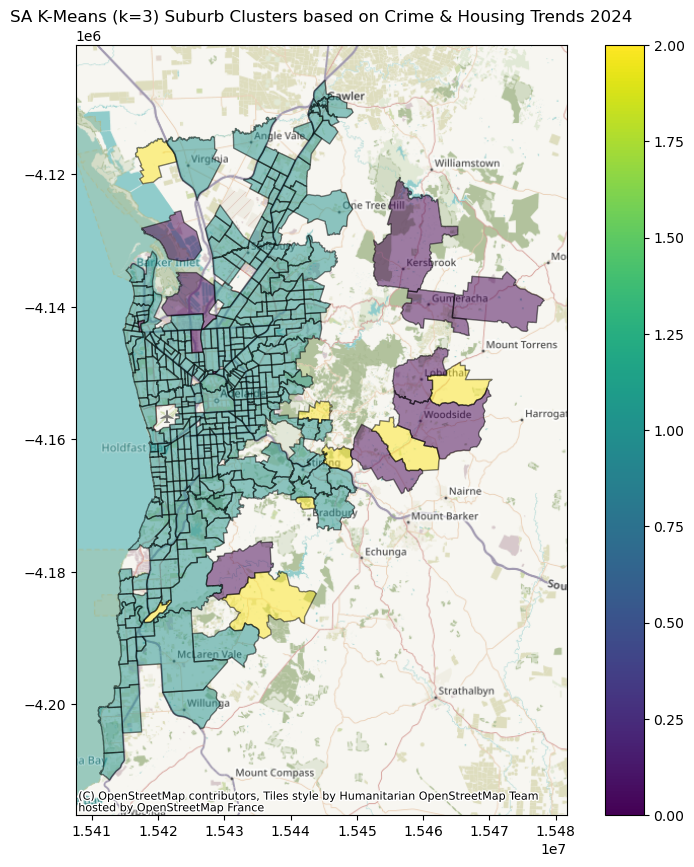

In [124]:
df_2024_sales = gdf_clusters[(gdf_clusters['year'] == 2024) & (gdf_clusters['sales'] != 0)].to_crs(epsg=3857)
ax = df_2024_sales.plot(column='k_mean_3_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA K-Means (k=3) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

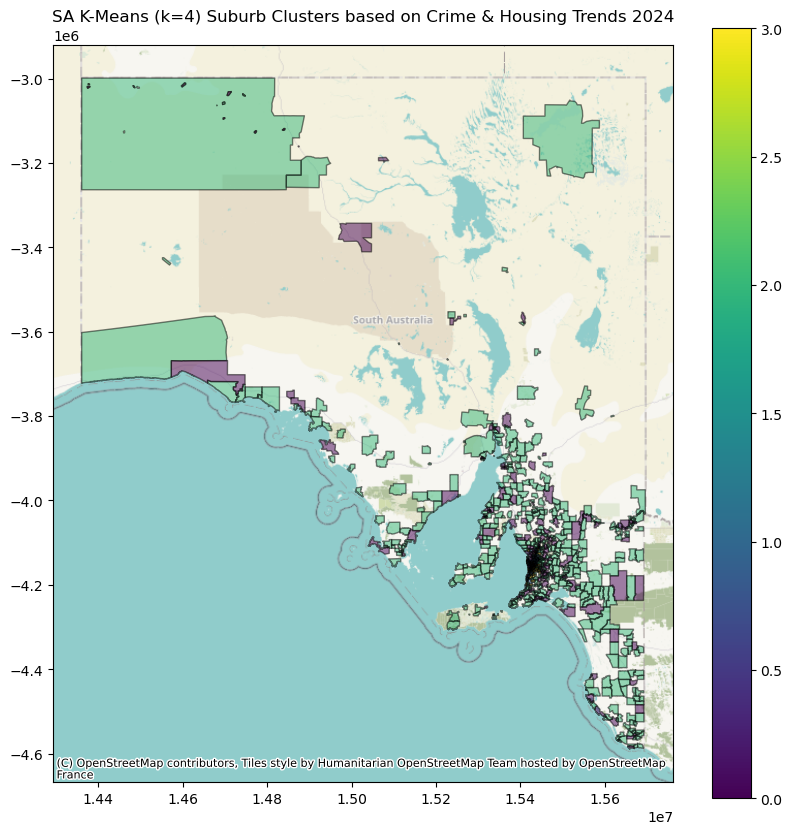

In [194]:
ax = df_2024.plot(column='k_mean_4_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA K-Means (k=4) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

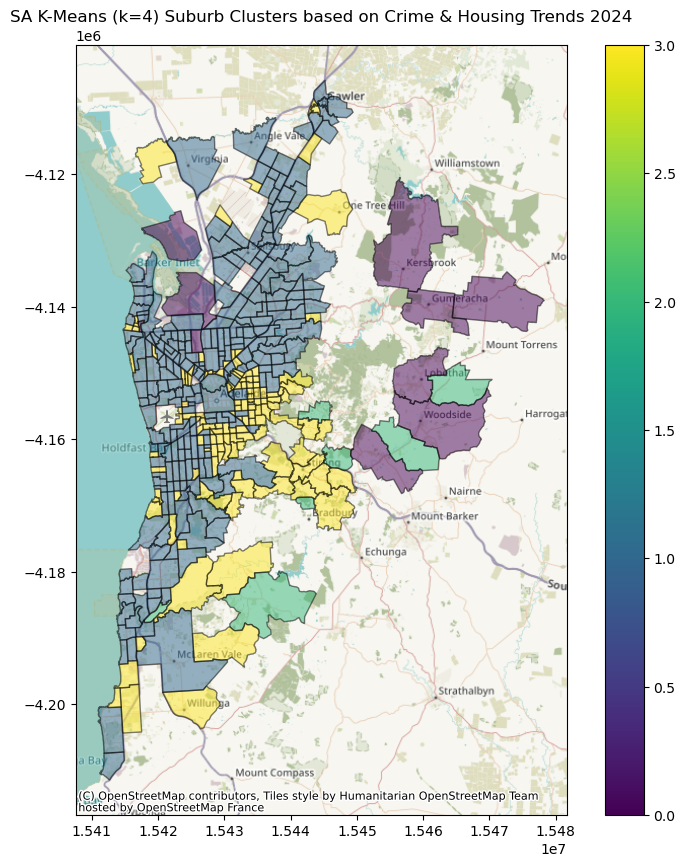

In [195]:
ax = df_2024_sales.plot(column='k_mean_4_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA K-Means (k=4) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

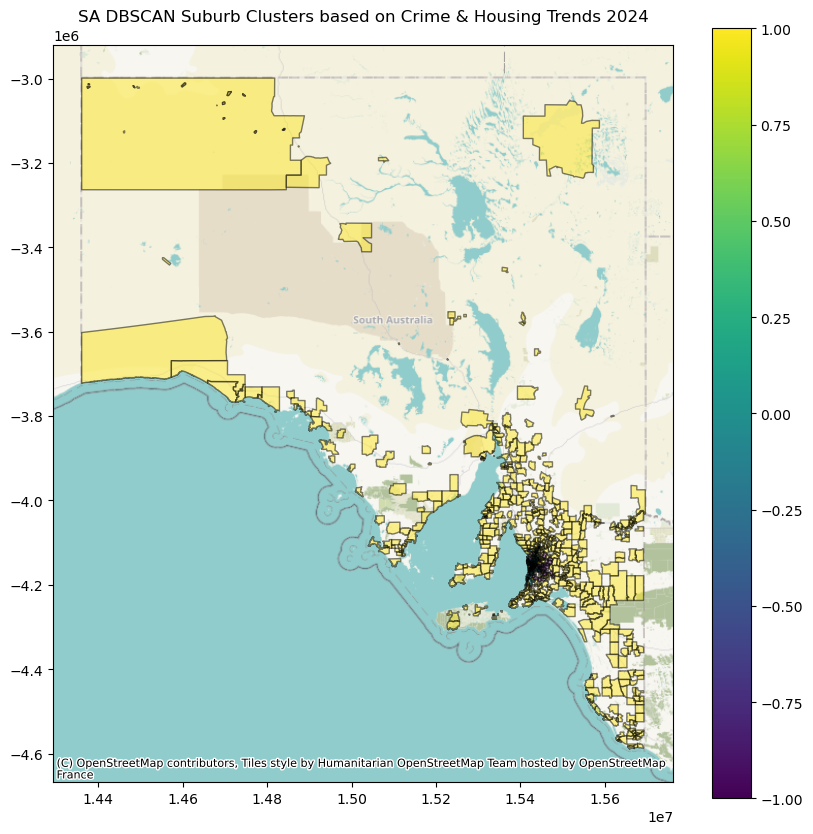

In [ ]:
ax = df_2024.plot(column='dbscan_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA DBSCAN Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

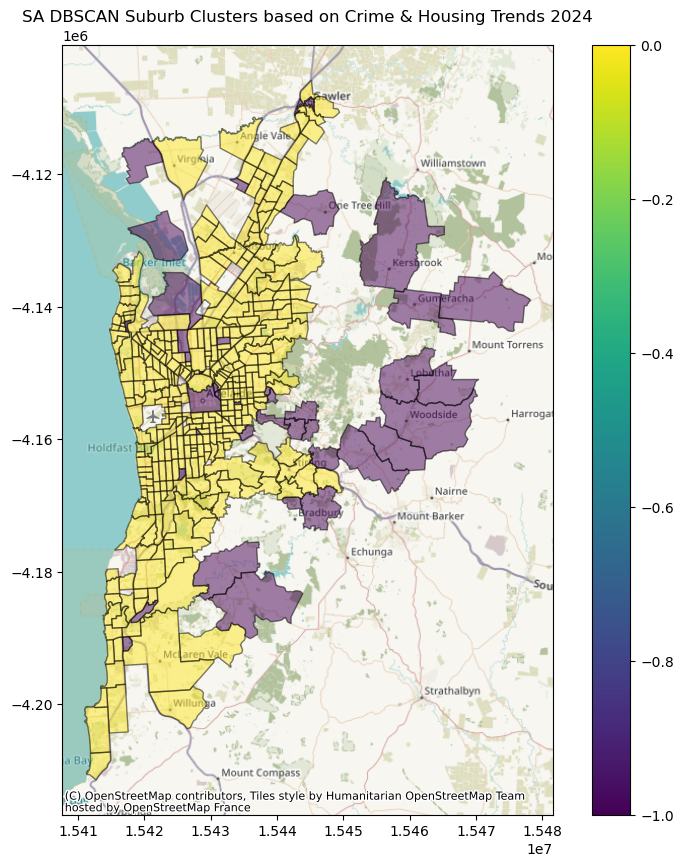

In [99]:
ax = df_2024_sales.plot(column='dbscan_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA DBSCAN Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

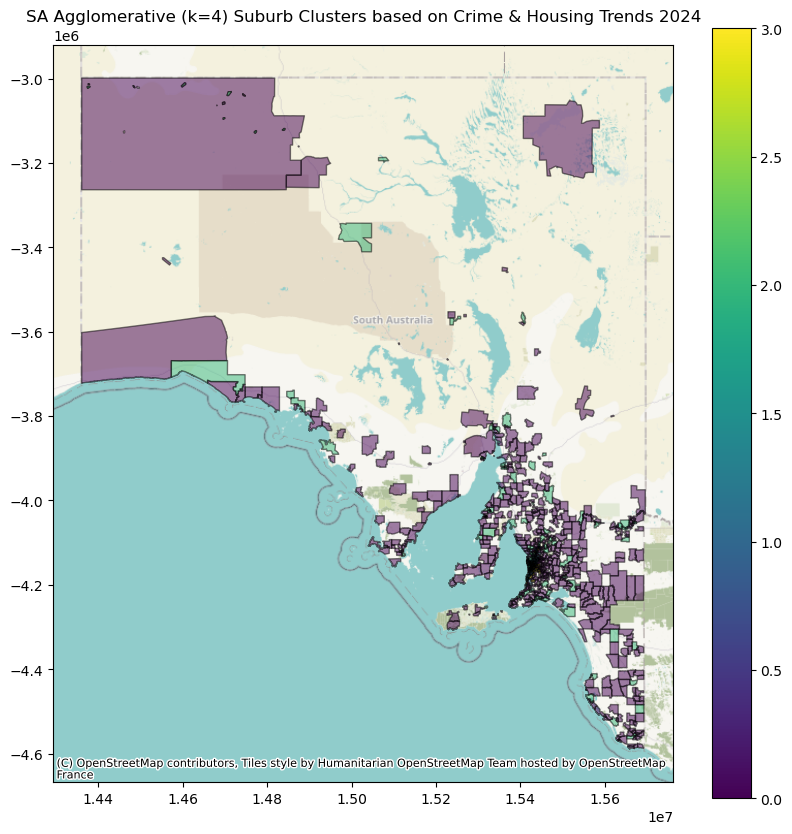

In [198]:
ax = df_2024.plot(column='agglo_4_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA Agglomerative (k=4) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)

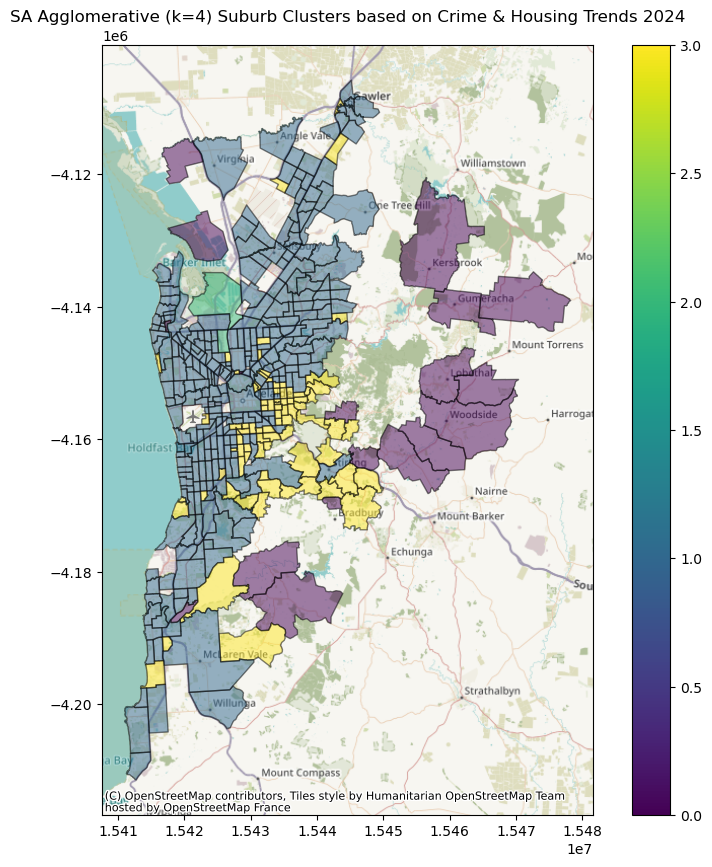

In [199]:
ax = df_2024_sales.plot(column='agglo_4_cluster', figsize=(10, 10), alpha=0.5, edgecolor="k", cmap="viridis", legend=True)
plt.title("SA Agglomerative (k=4) Suburb Clusters based on Crime & Housing Trends 2024")
cx.add_basemap(ax)